## Short Introduction
This notebook focuses on forecasting SUV sales by utilizing time series analysis techniques such as ARIMA, ETS (Exponential Smoothing), and TSL (Time Series Learning) models. Through these methods, I analyzed historical sales data to uncover trends, seasonality, and patterns that can inform future sales predictions. The objective is to assist automotive businesses in making data-driven decisions related to inventory planning, marketing strategies, and overall sales forecasting.

## Libraries and Data
For this task, I used the **fpp3** library, which provides all the necessary tools and functions for time series analysis. 

In [61]:
library(fpp3)

In [62]:
suv <- aus_vehicle_sales |> filter(Type == "SUV")

## Train/Test Split

In [63]:
suv_train <- suv |> filter(year(Month) <= 2015)

## Exploratory Data Analysis

In [64]:
options(repr.plot.width = 20, repr.plot.height = 12)

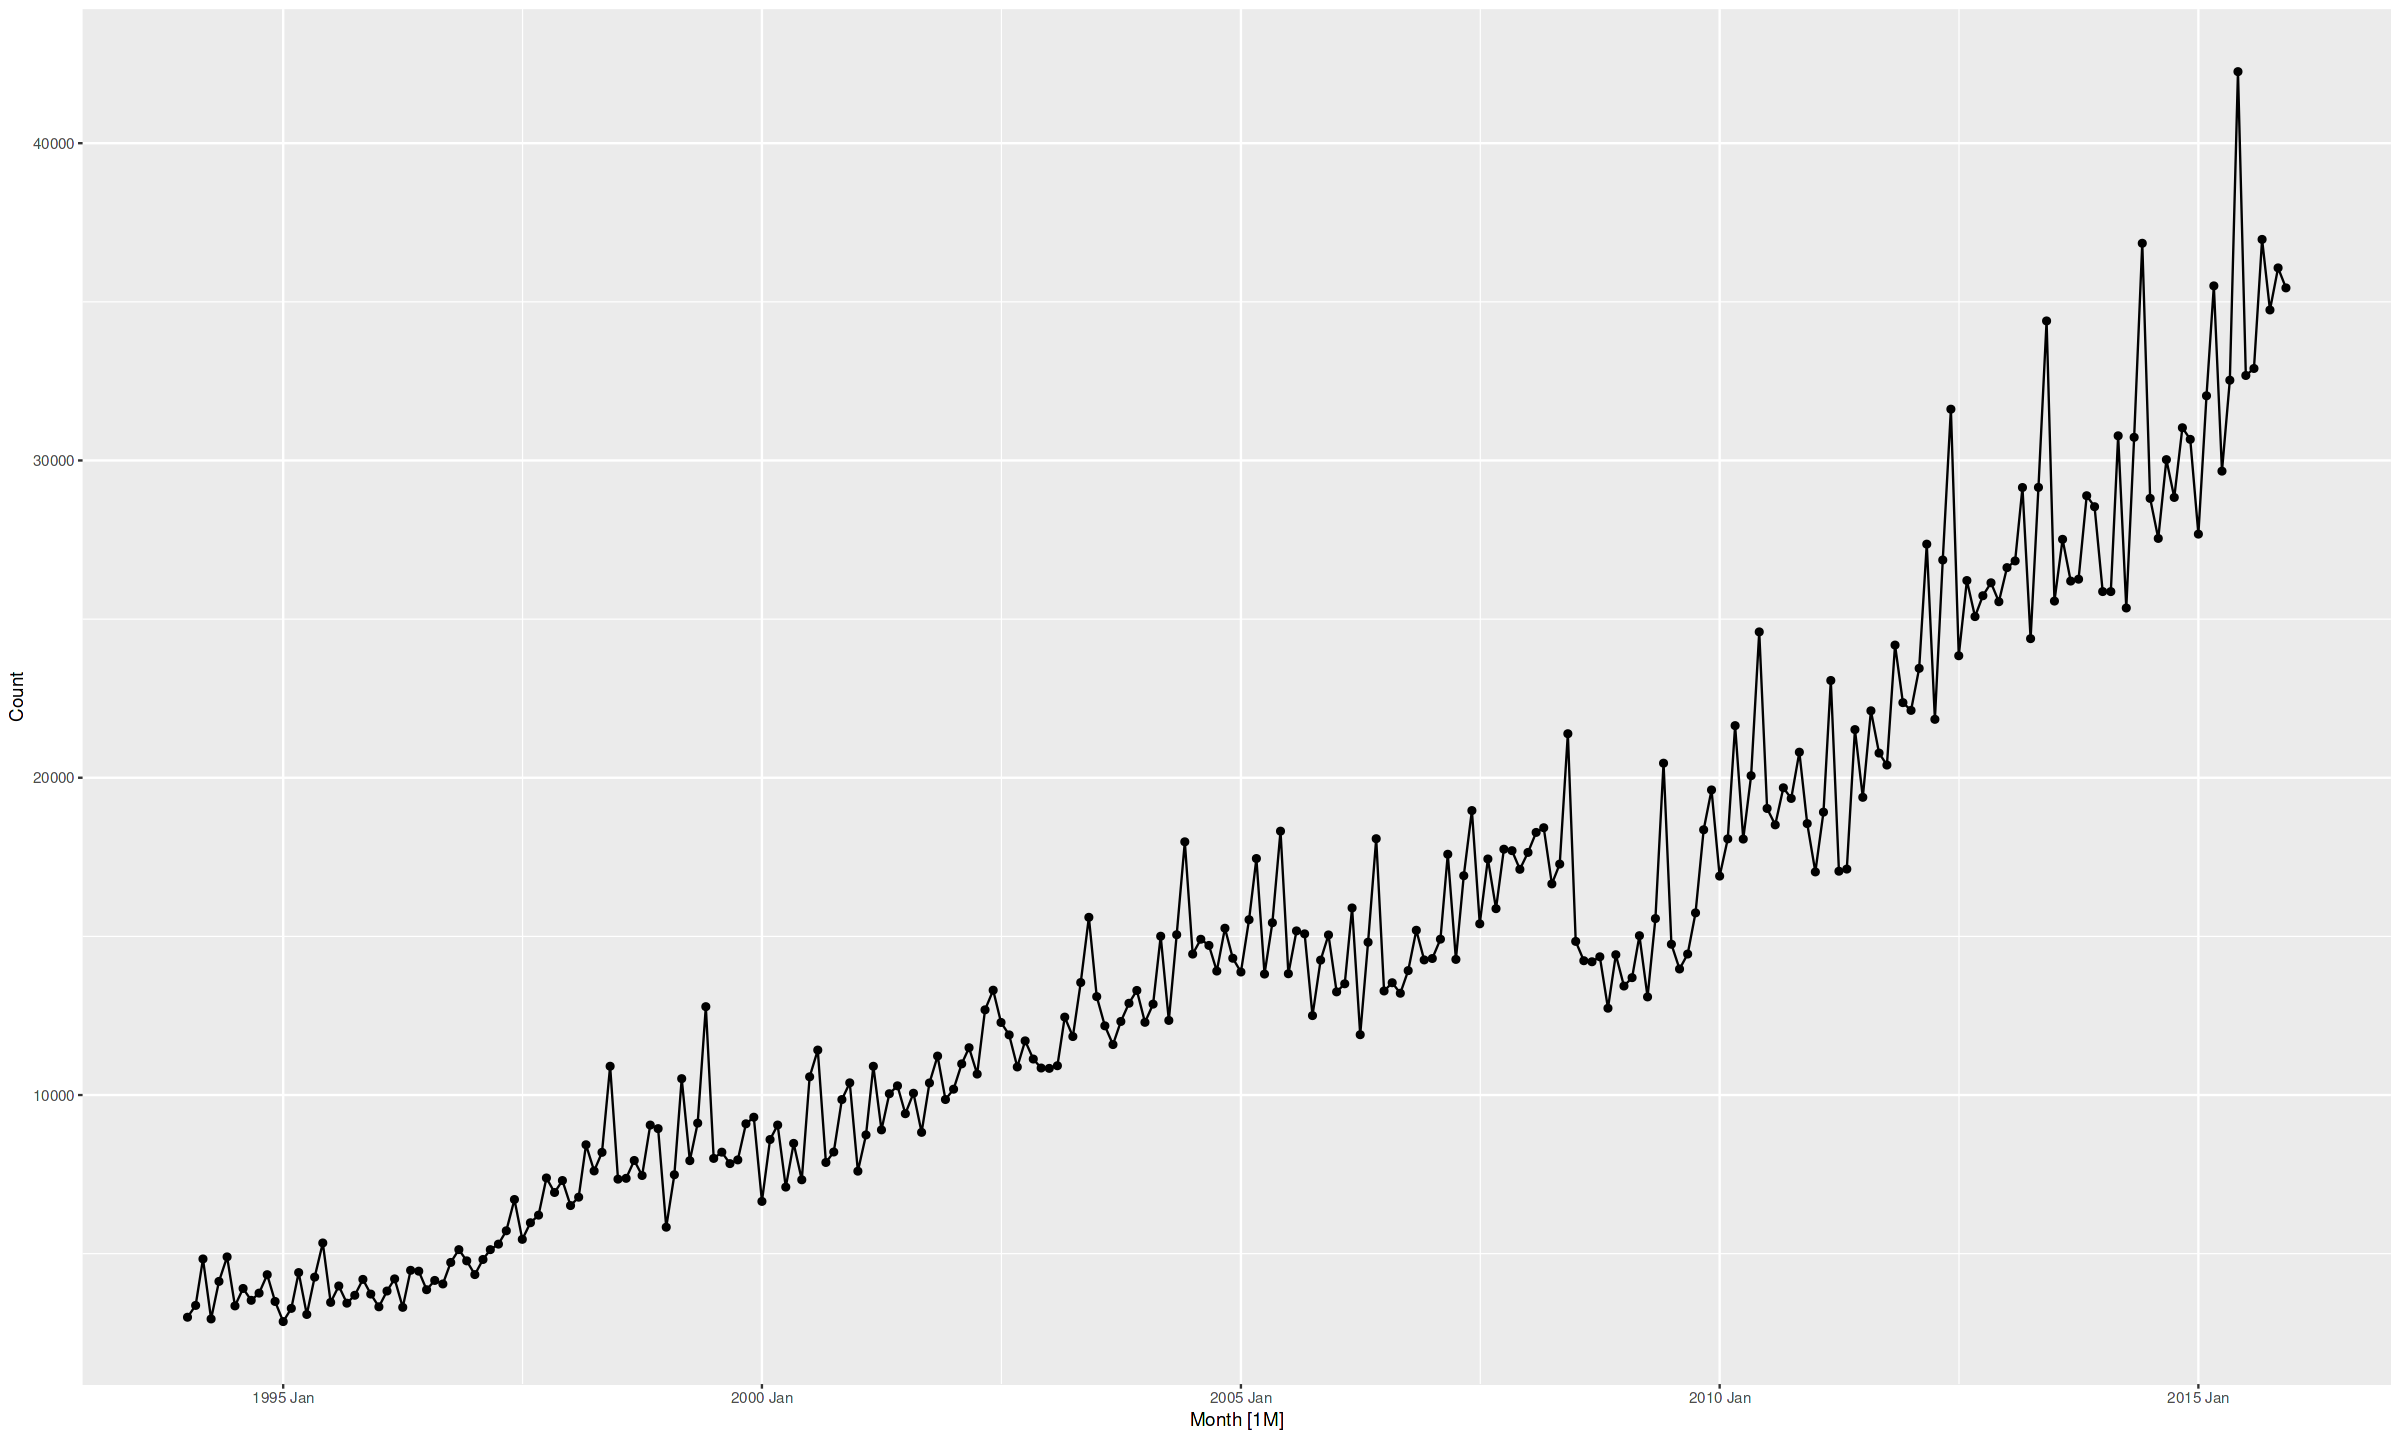

In [65]:
suv_train |> autoplot(Count) + geom_point()

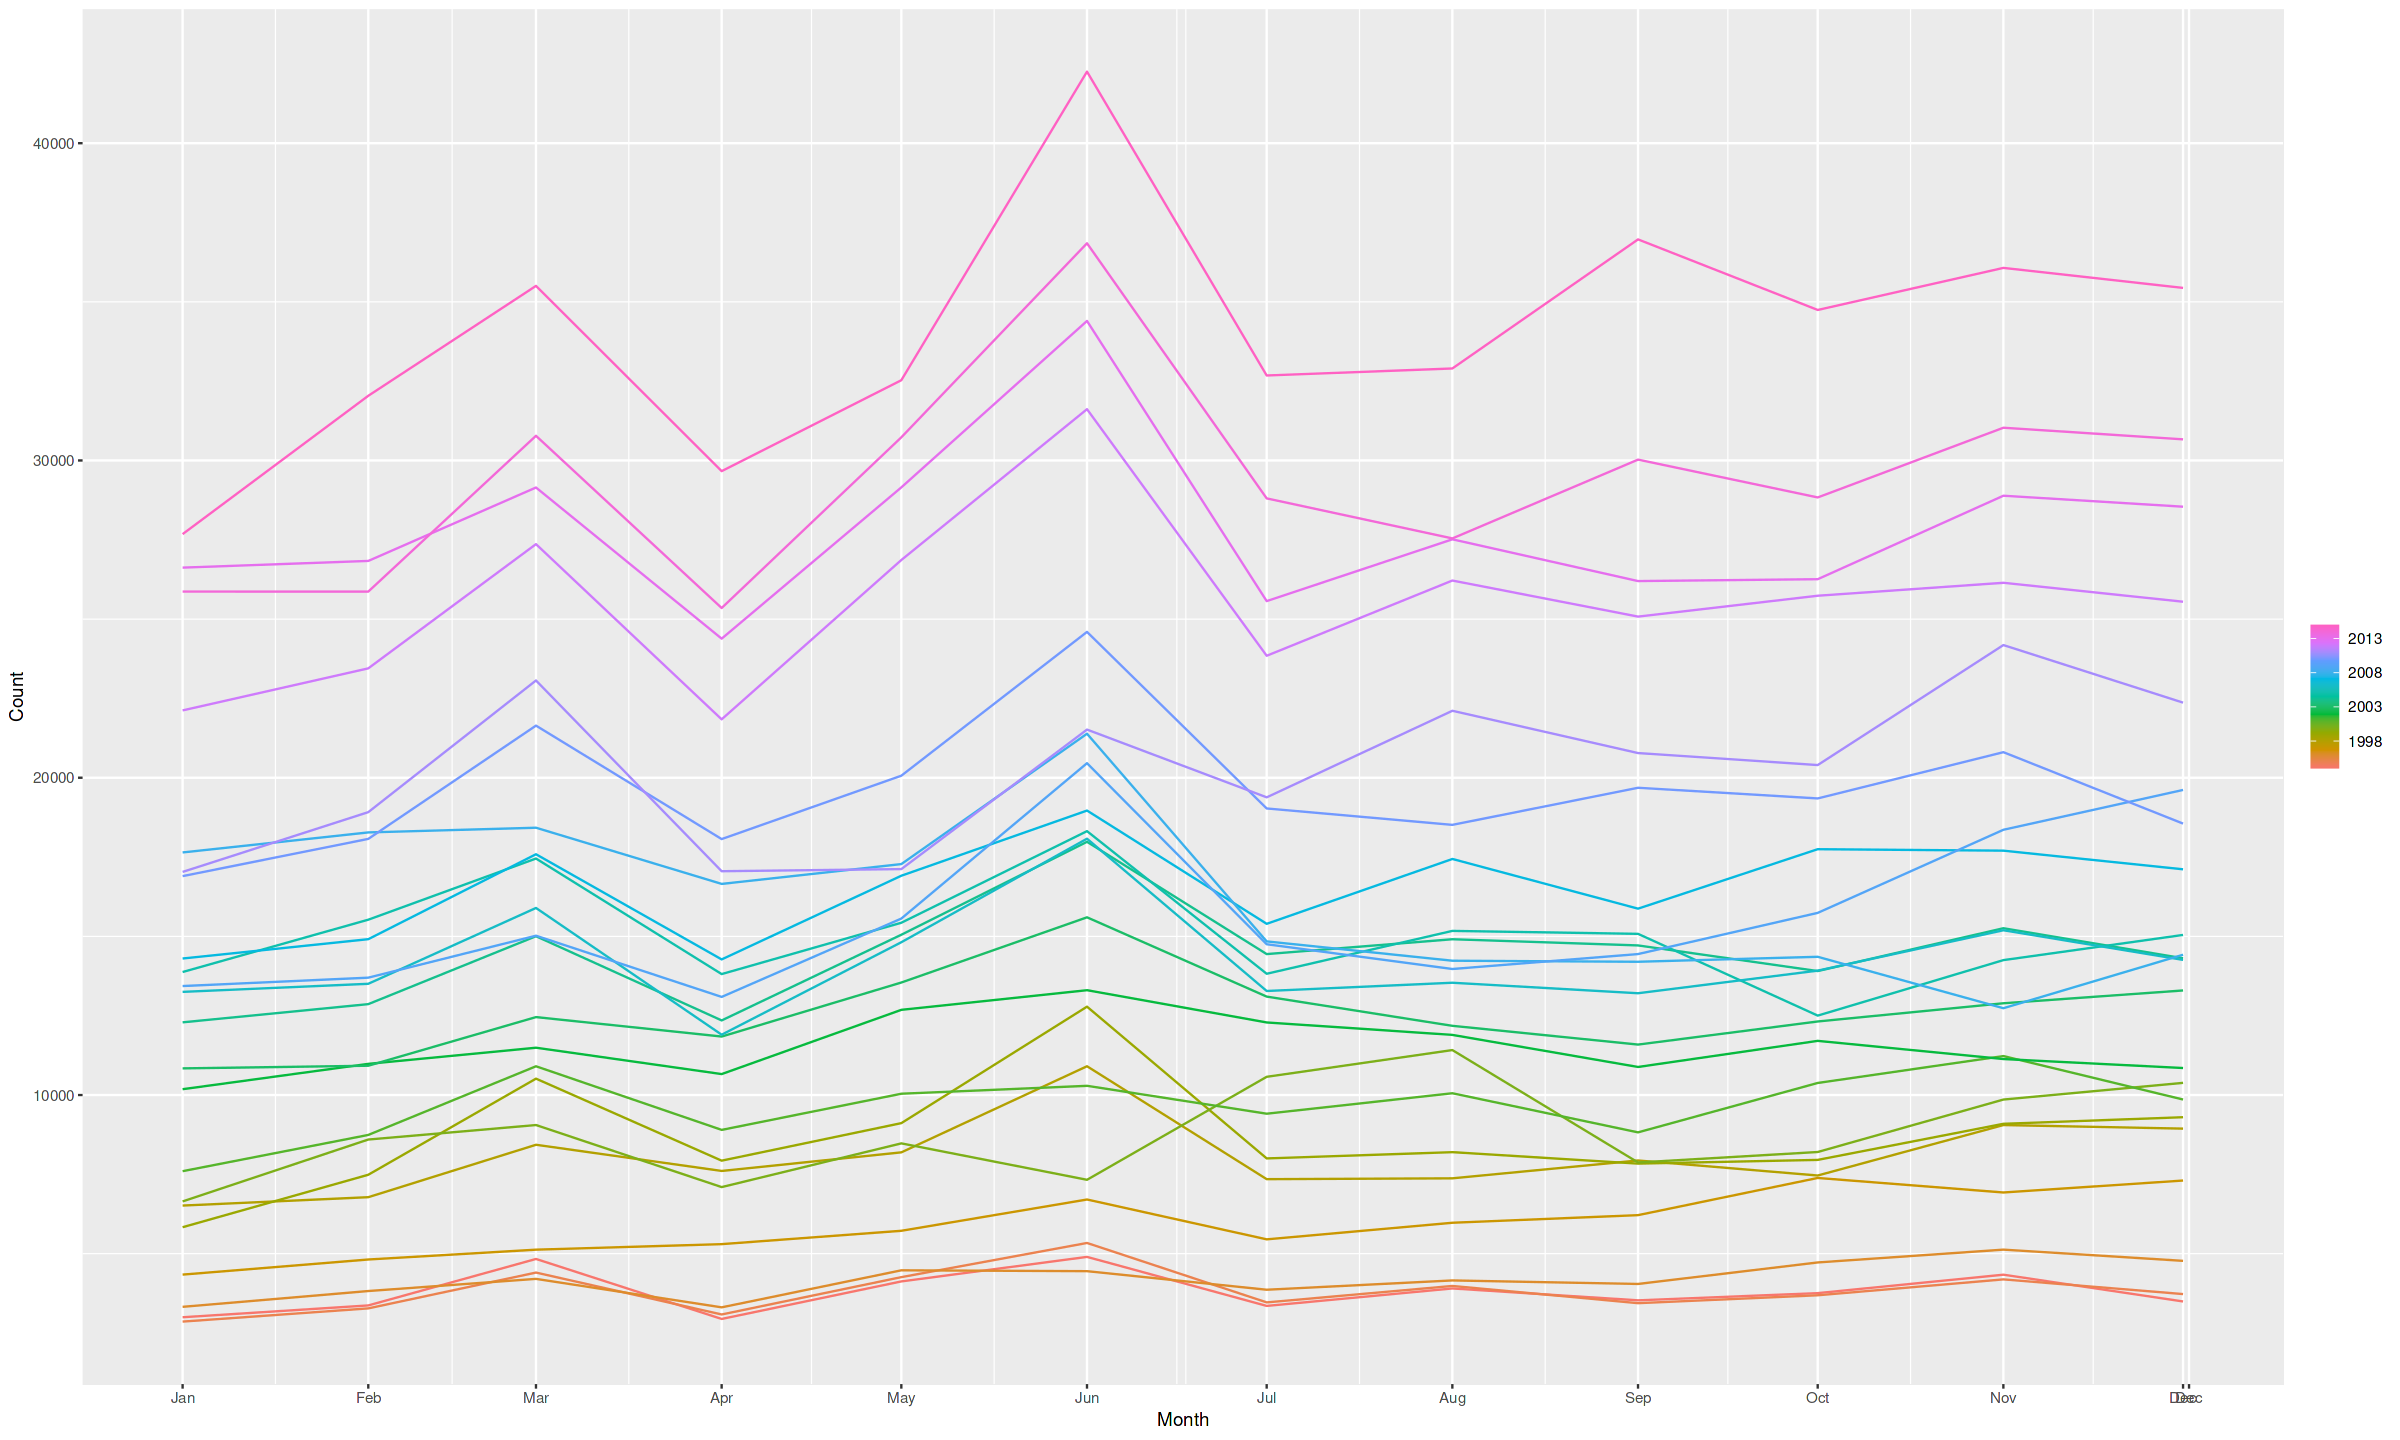

In [66]:
suv_train |> gg_season(Count)

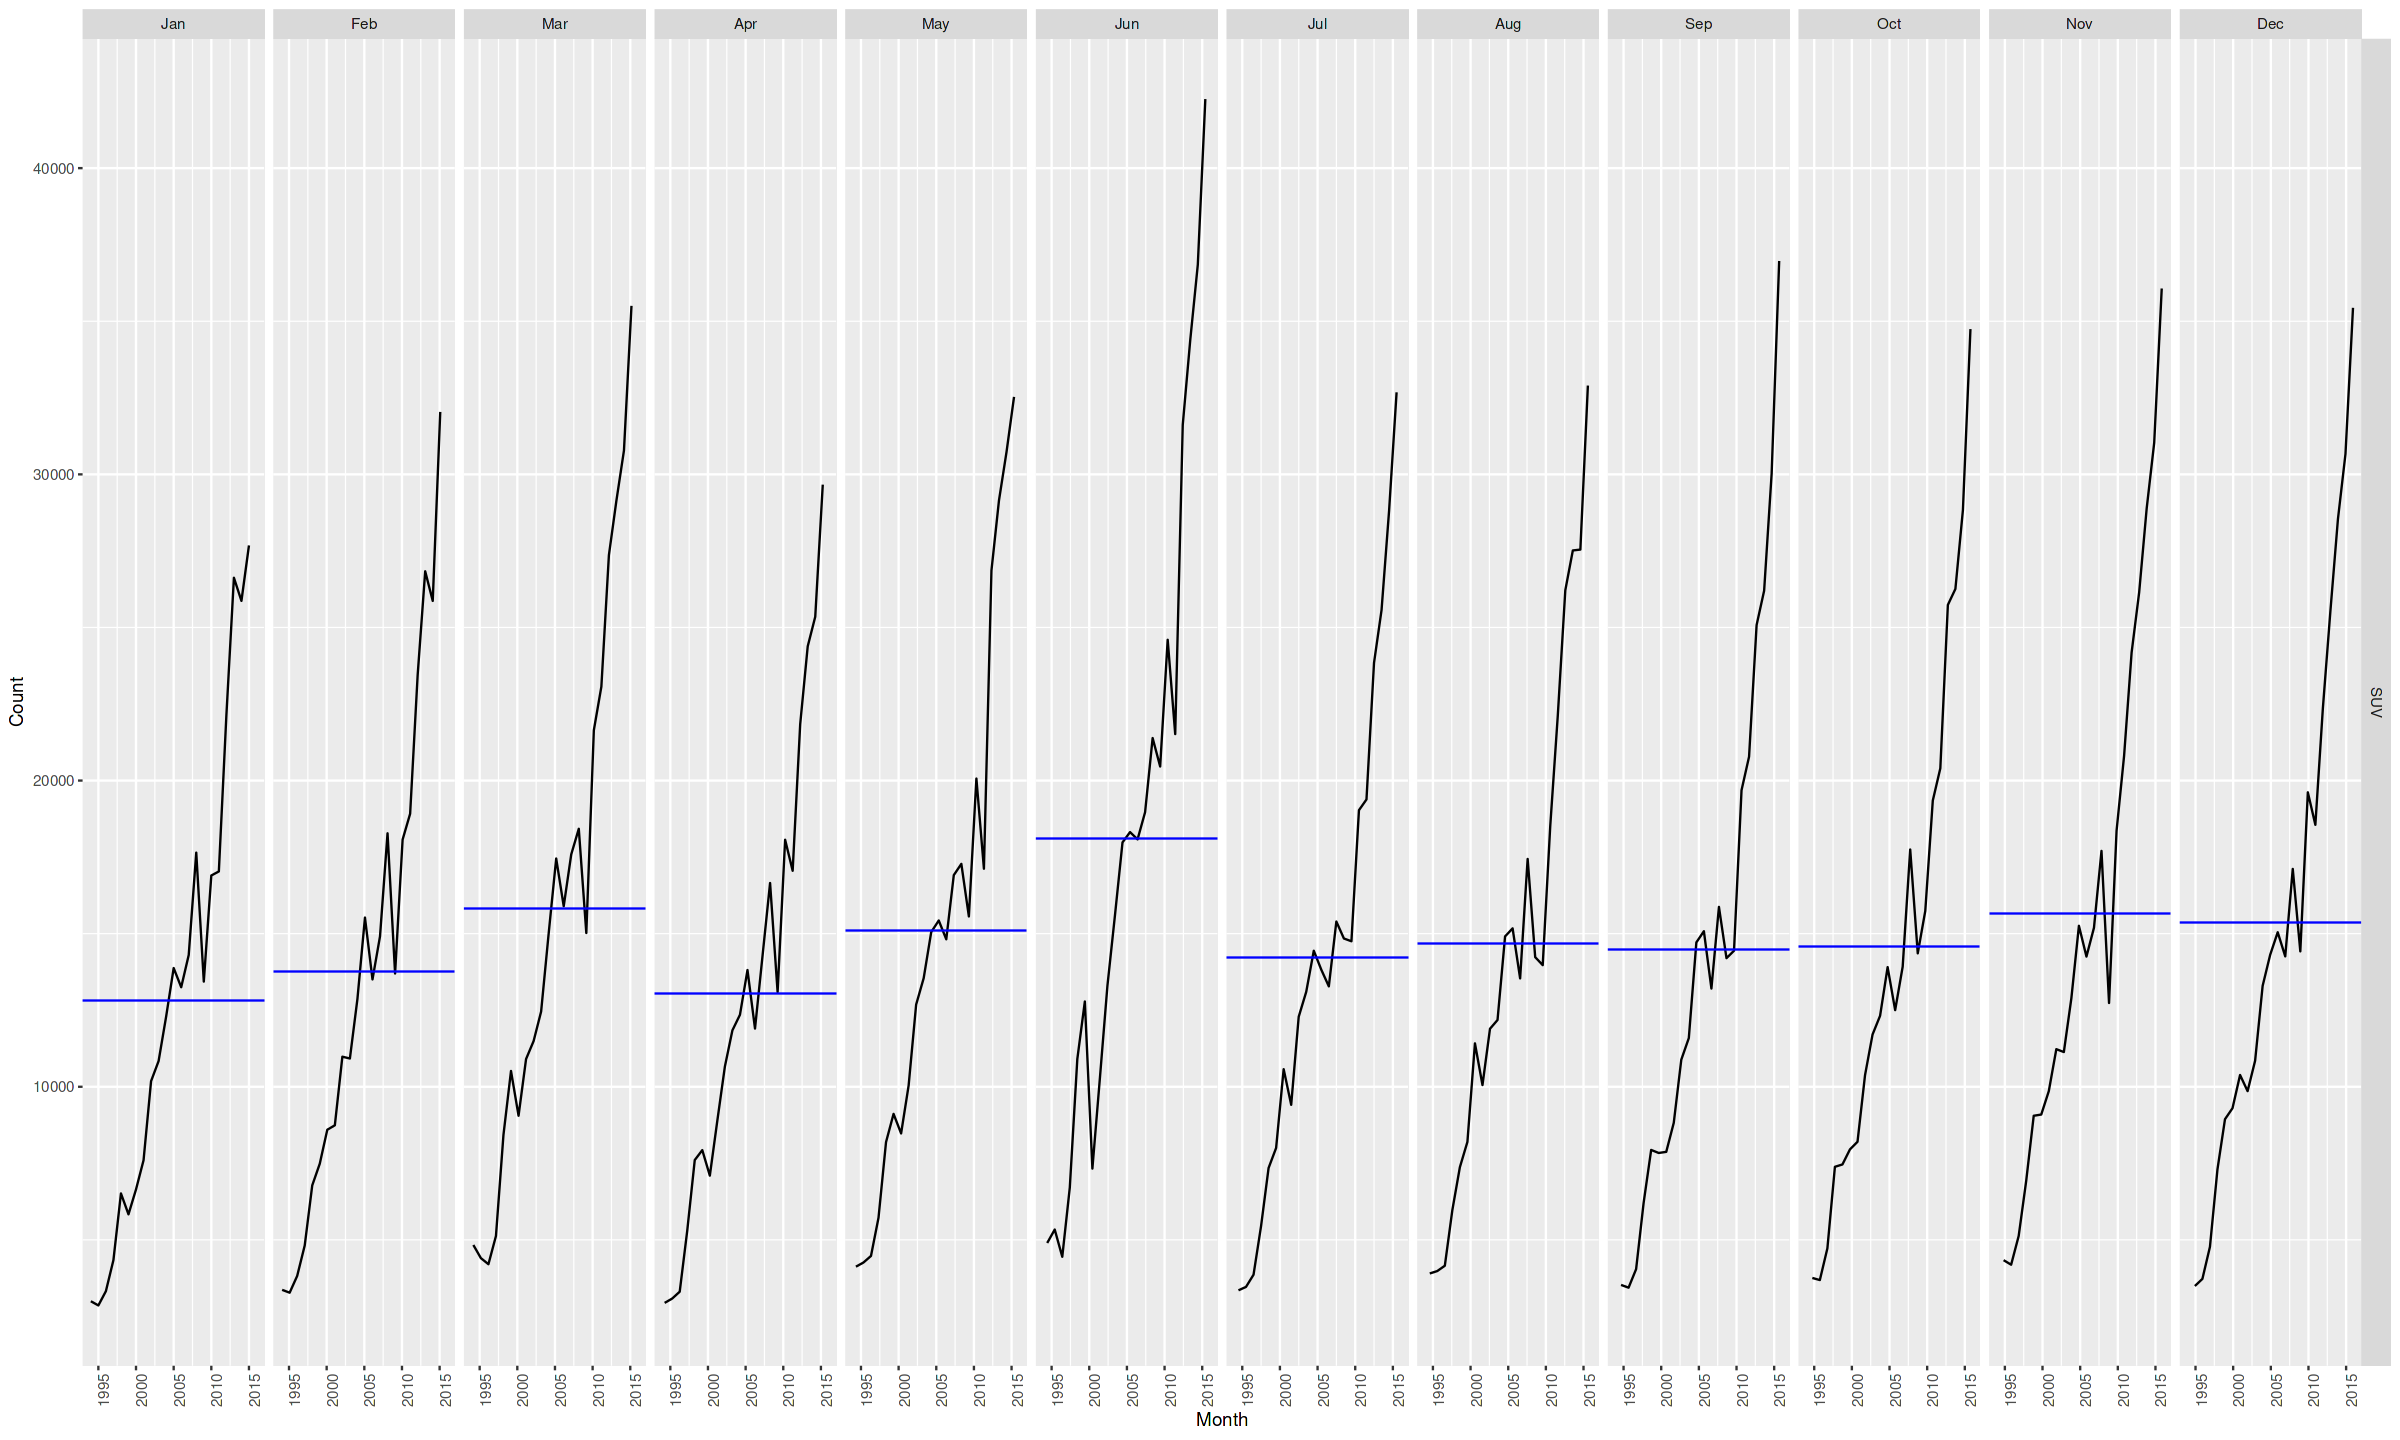

In [67]:
suv_train |> gg_subseries(Count)

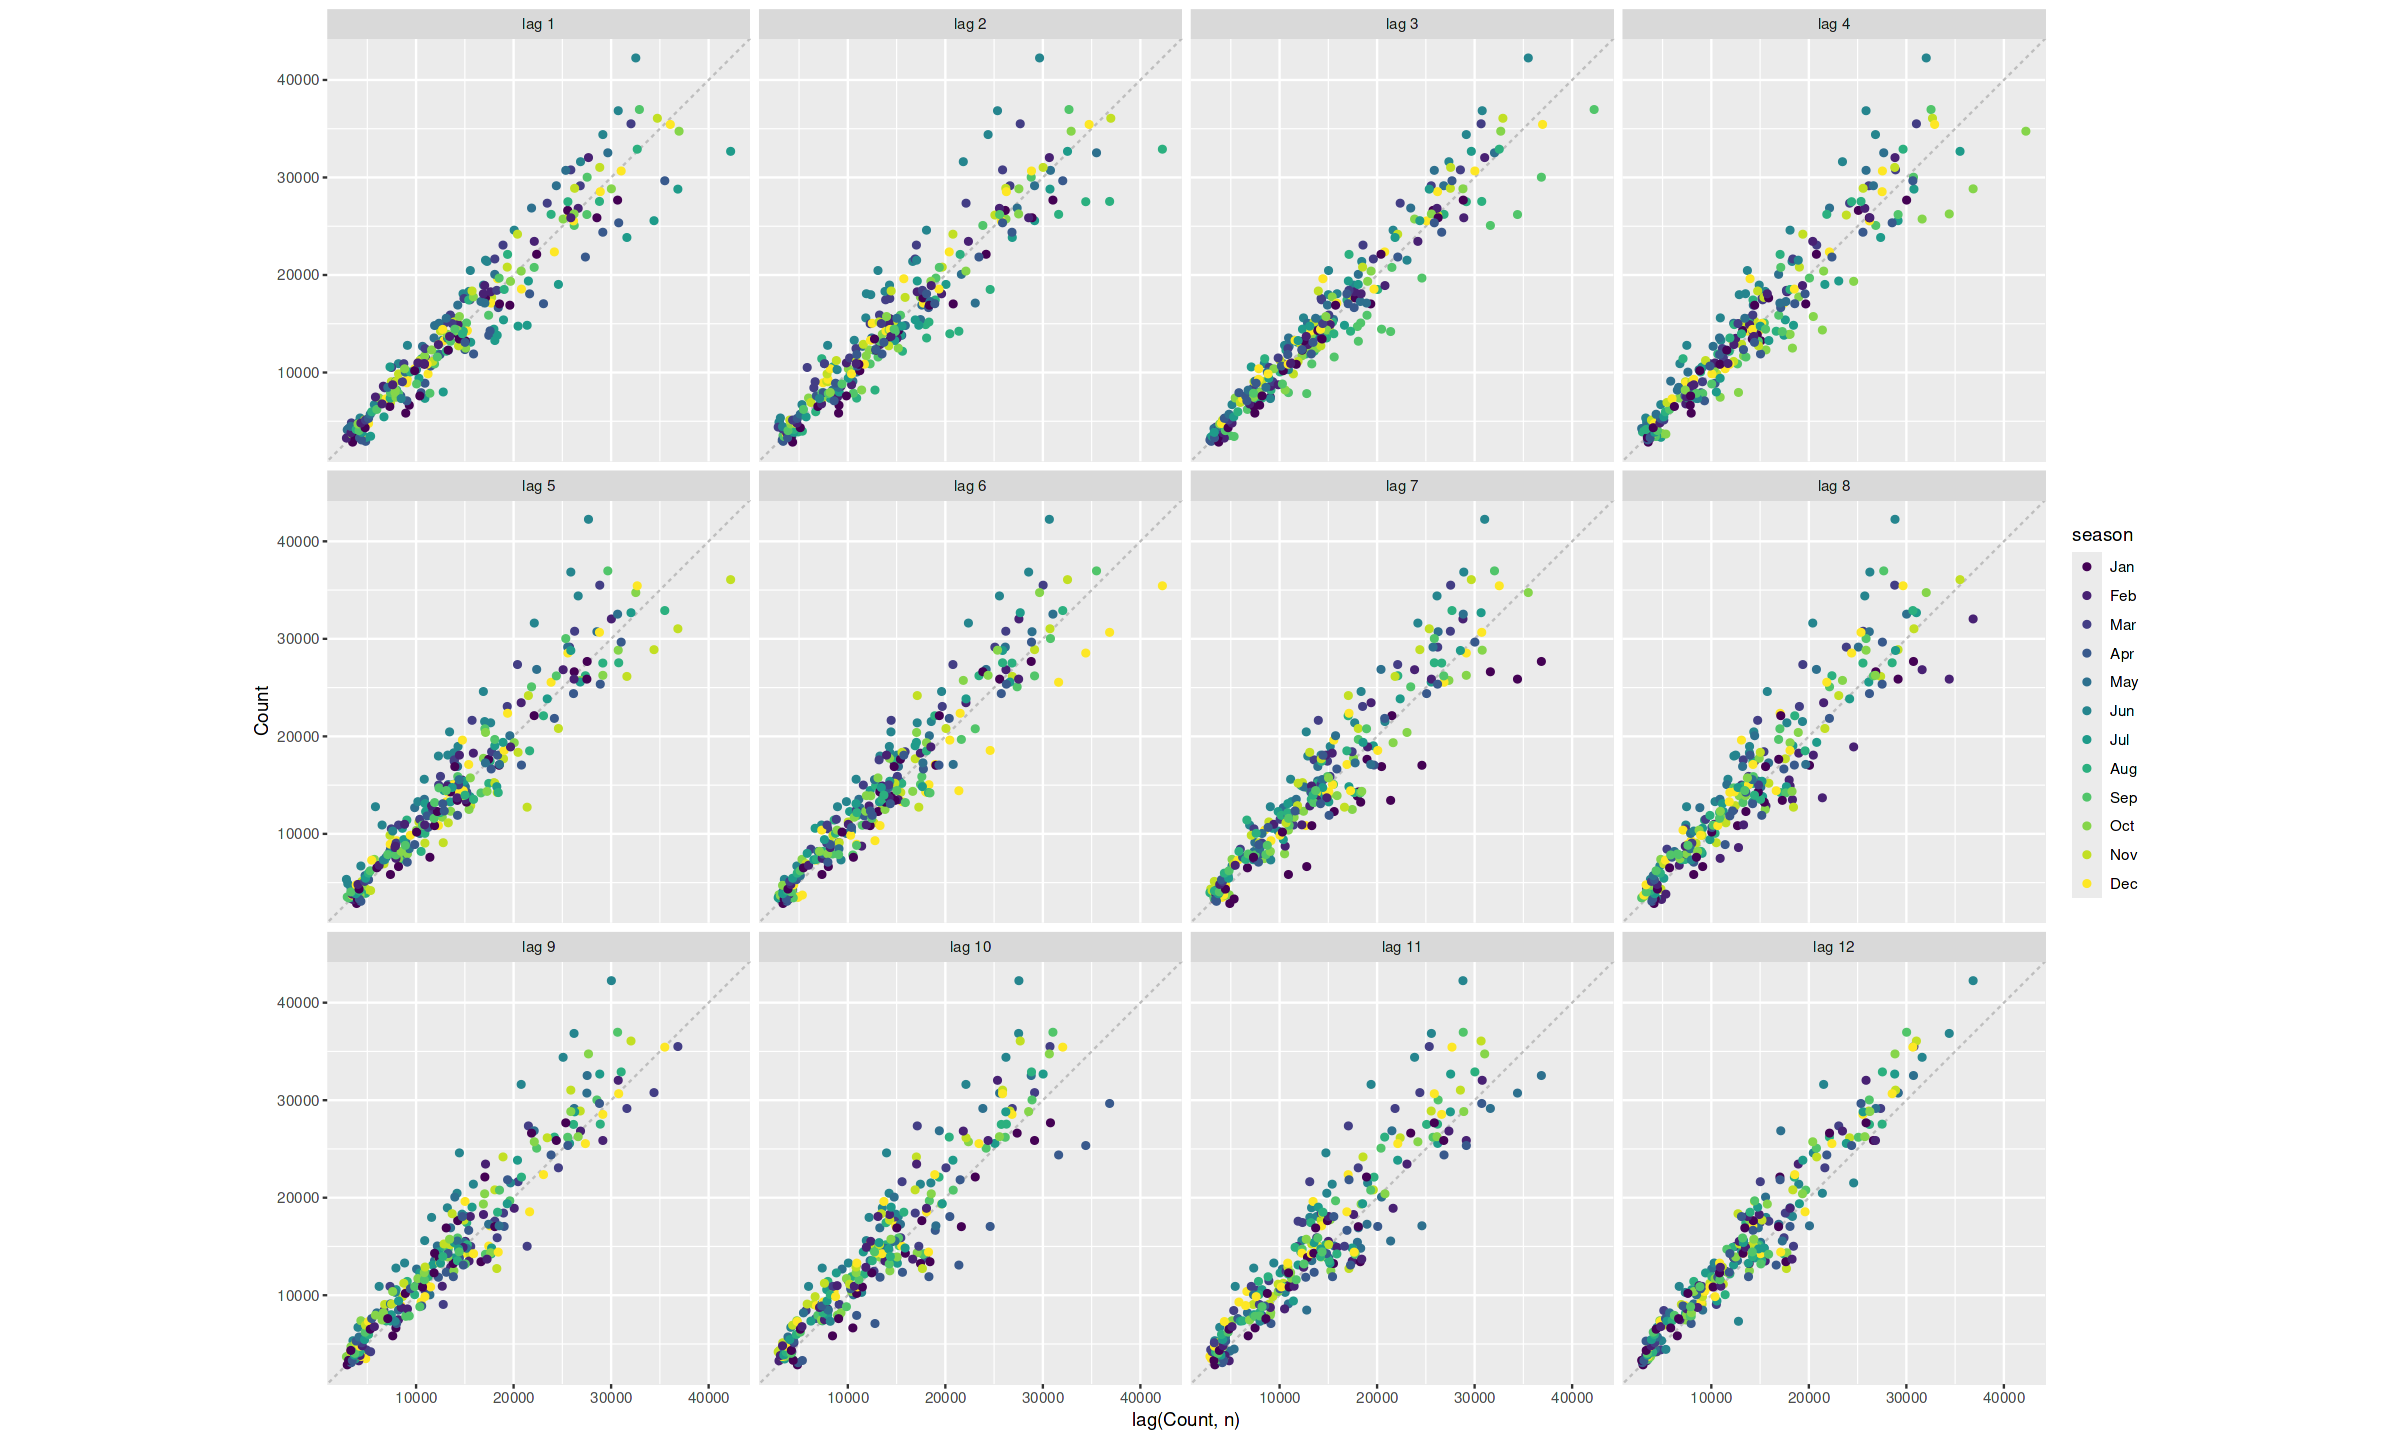

In [68]:
suv_train |> gg_lag(Count, geom = "point", lags = 1:12)

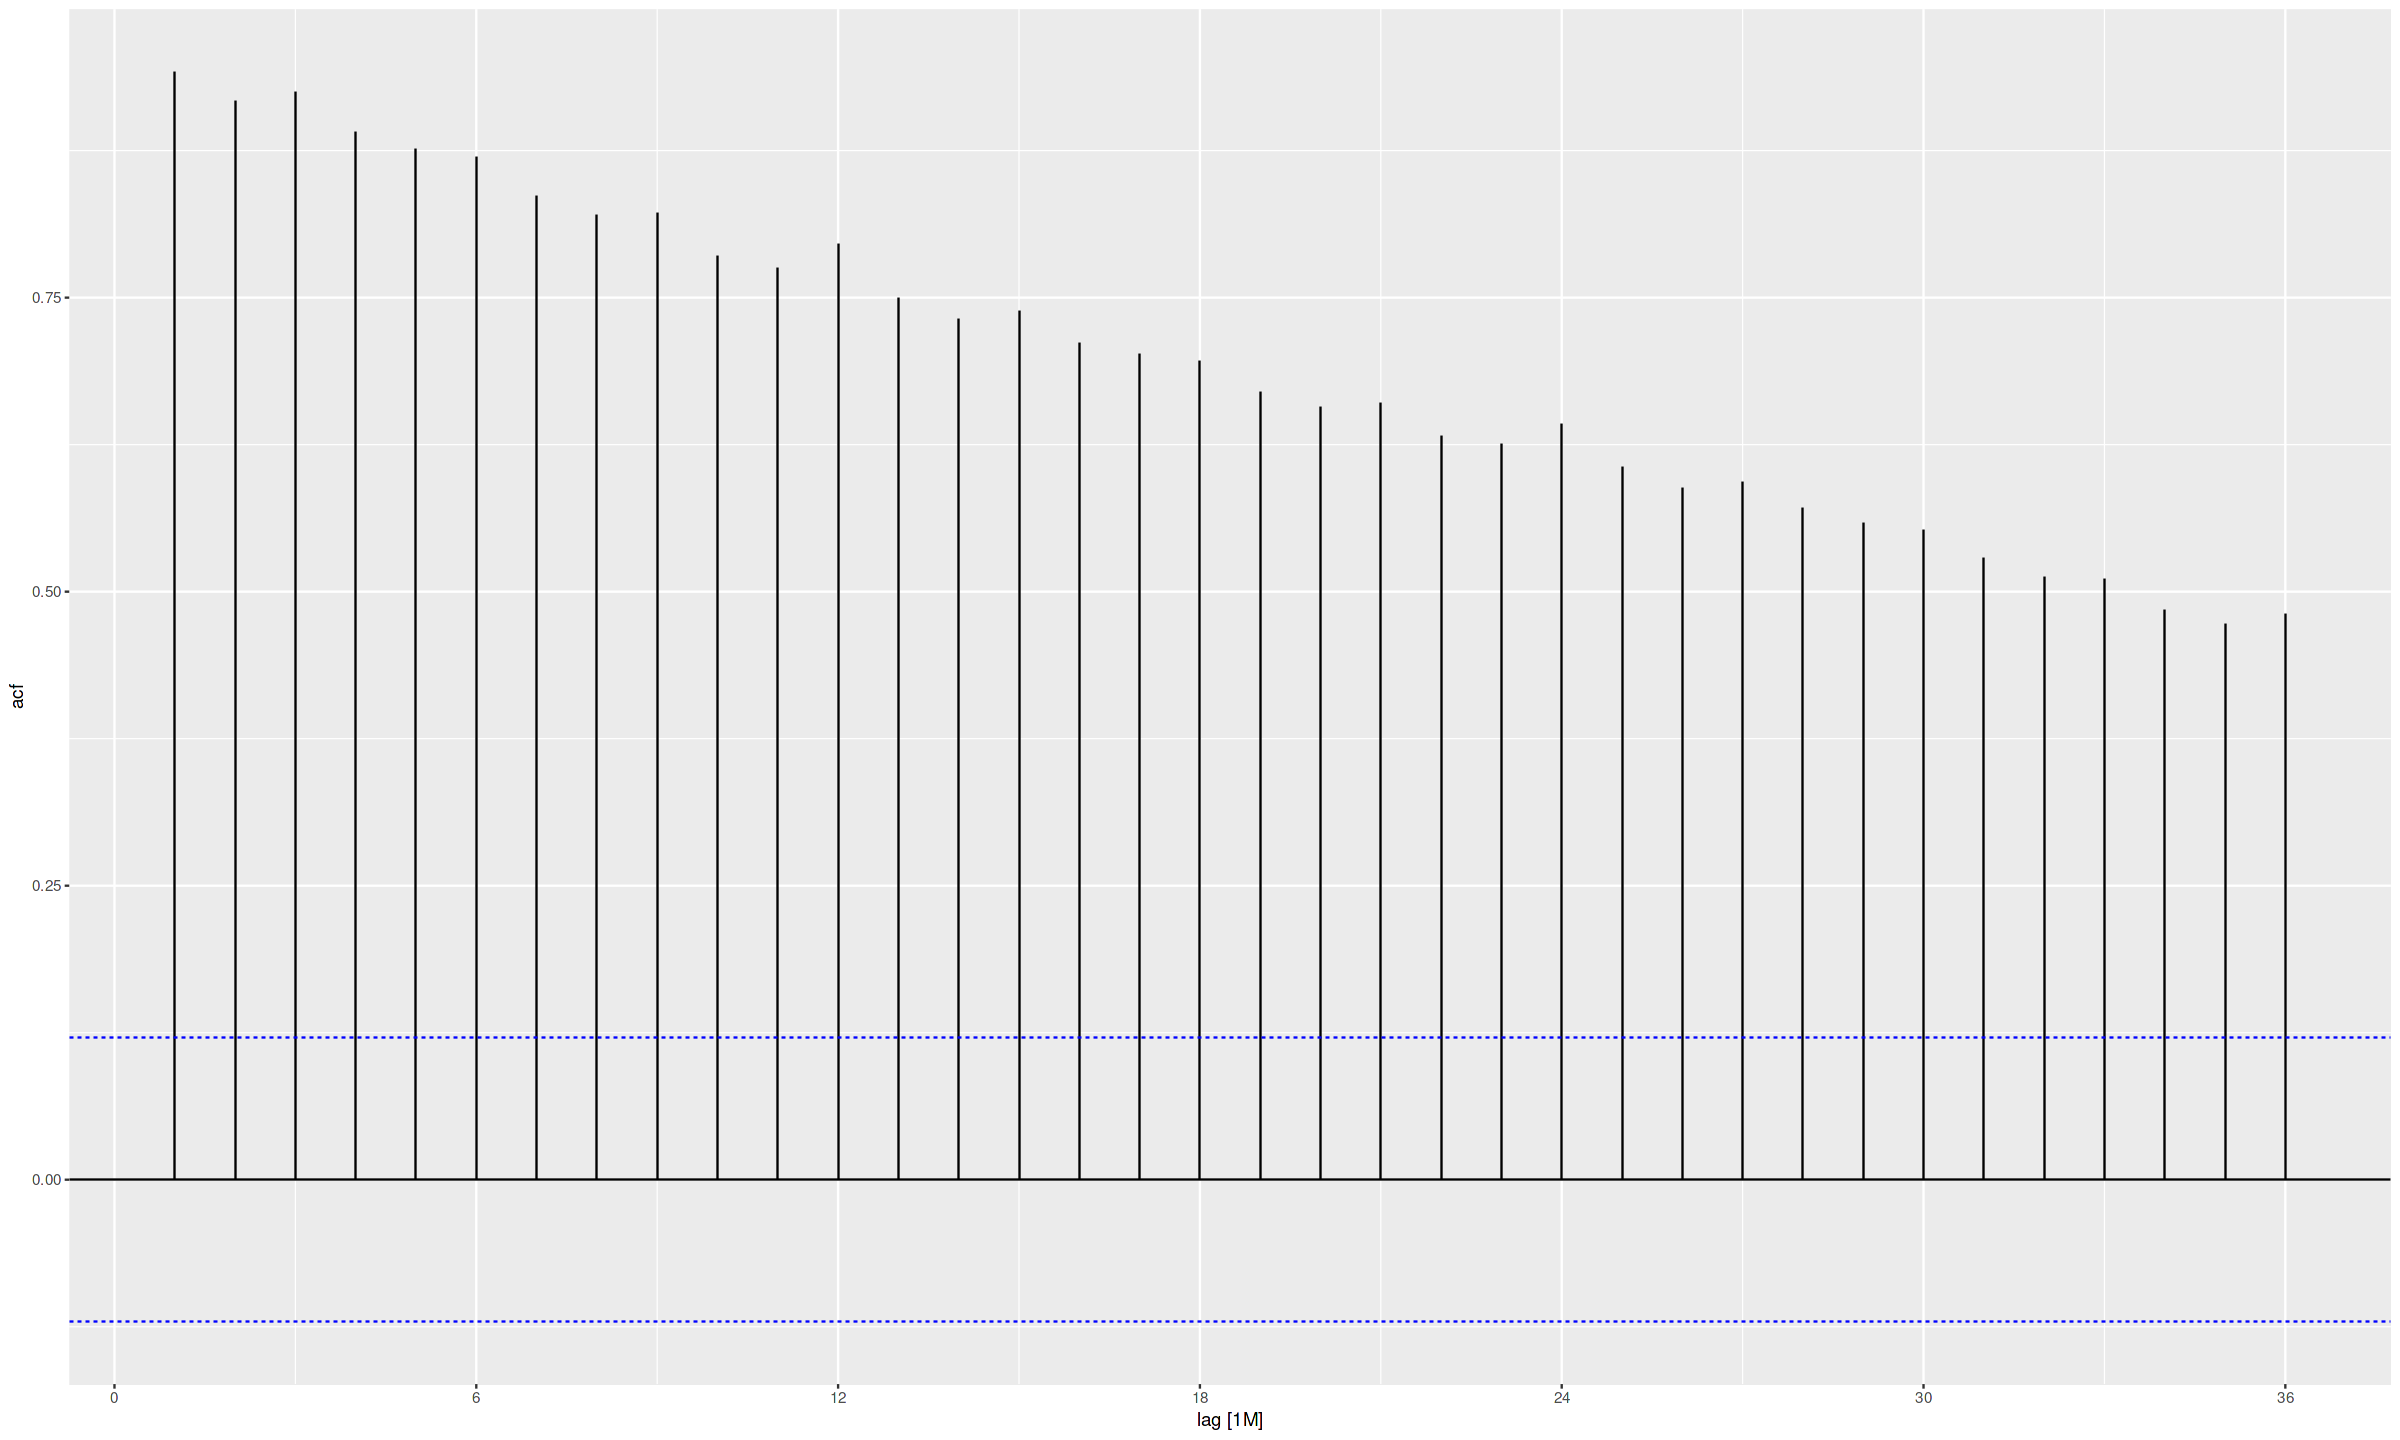

In [69]:
suv_train |> ACF(Count, lag_max = 36) |> autoplot()

## Data Transformation and Decomposition

In [70]:
lambda <- suv_train |> features(Count, features = guerrero) |> pull(lambda_guerrero)
lambda

[1] 0.2573108

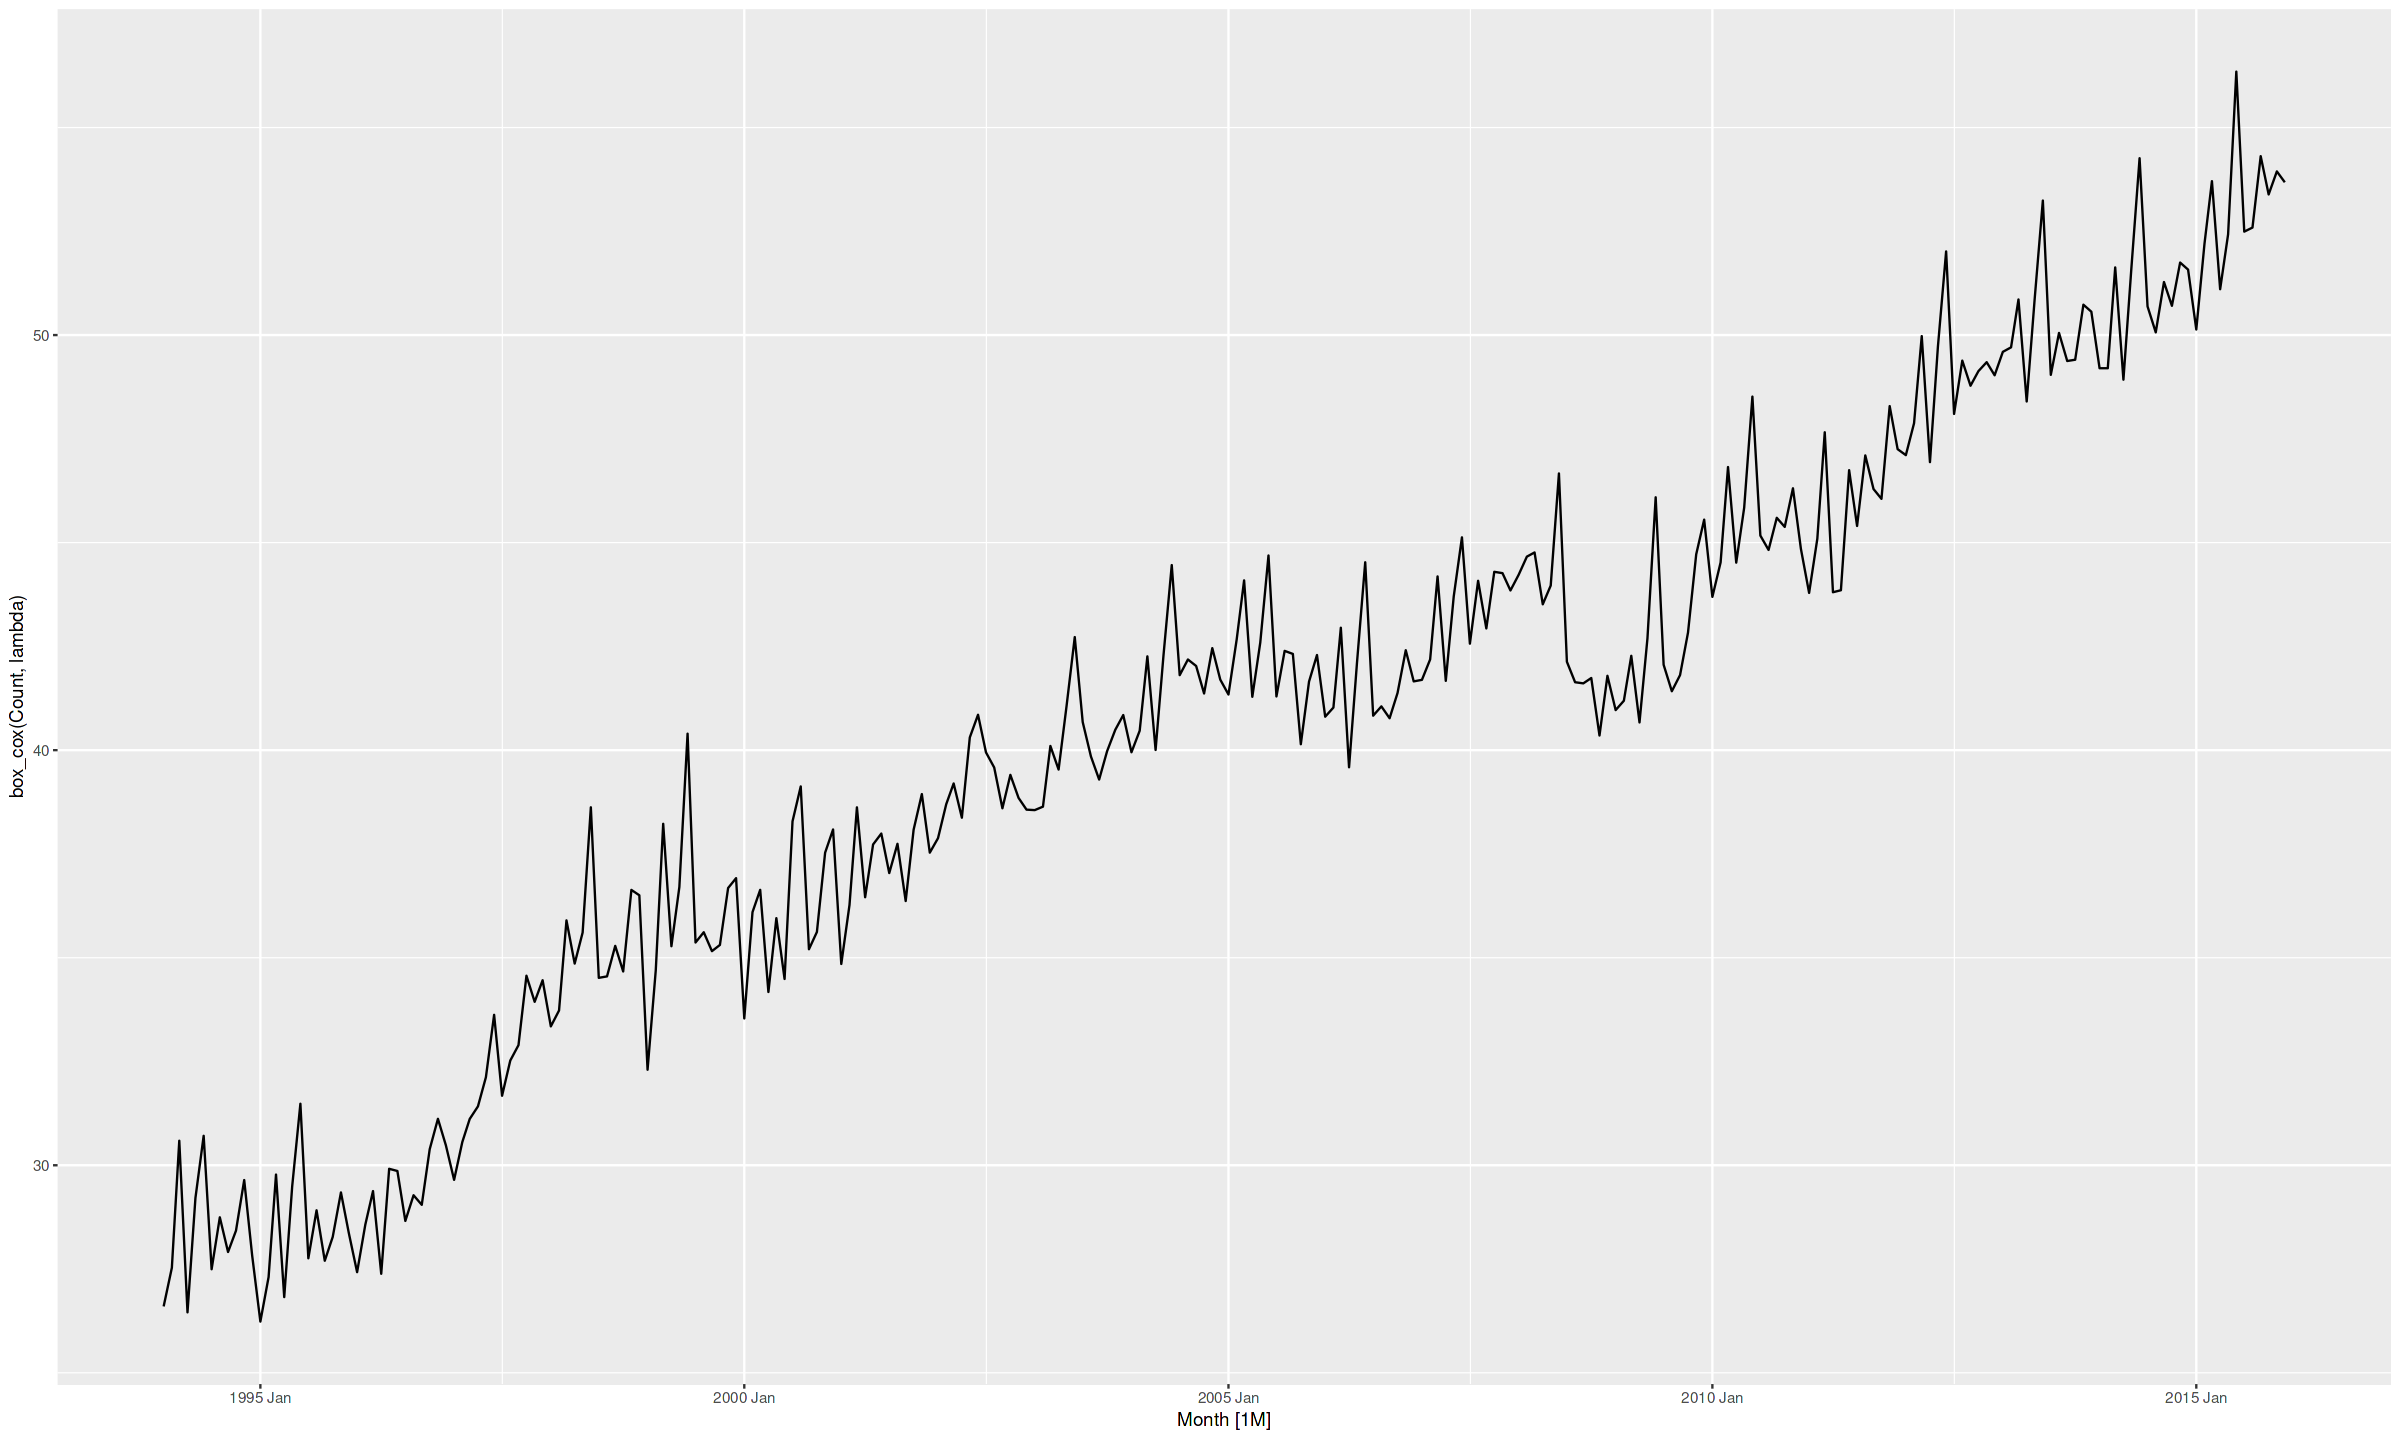

In [71]:
suv_train |> autoplot(box_cox(Count, lambda))

In [72]:
dcmp <- suv_train |> model(stl = STL(box_cox(Count, lambda)))

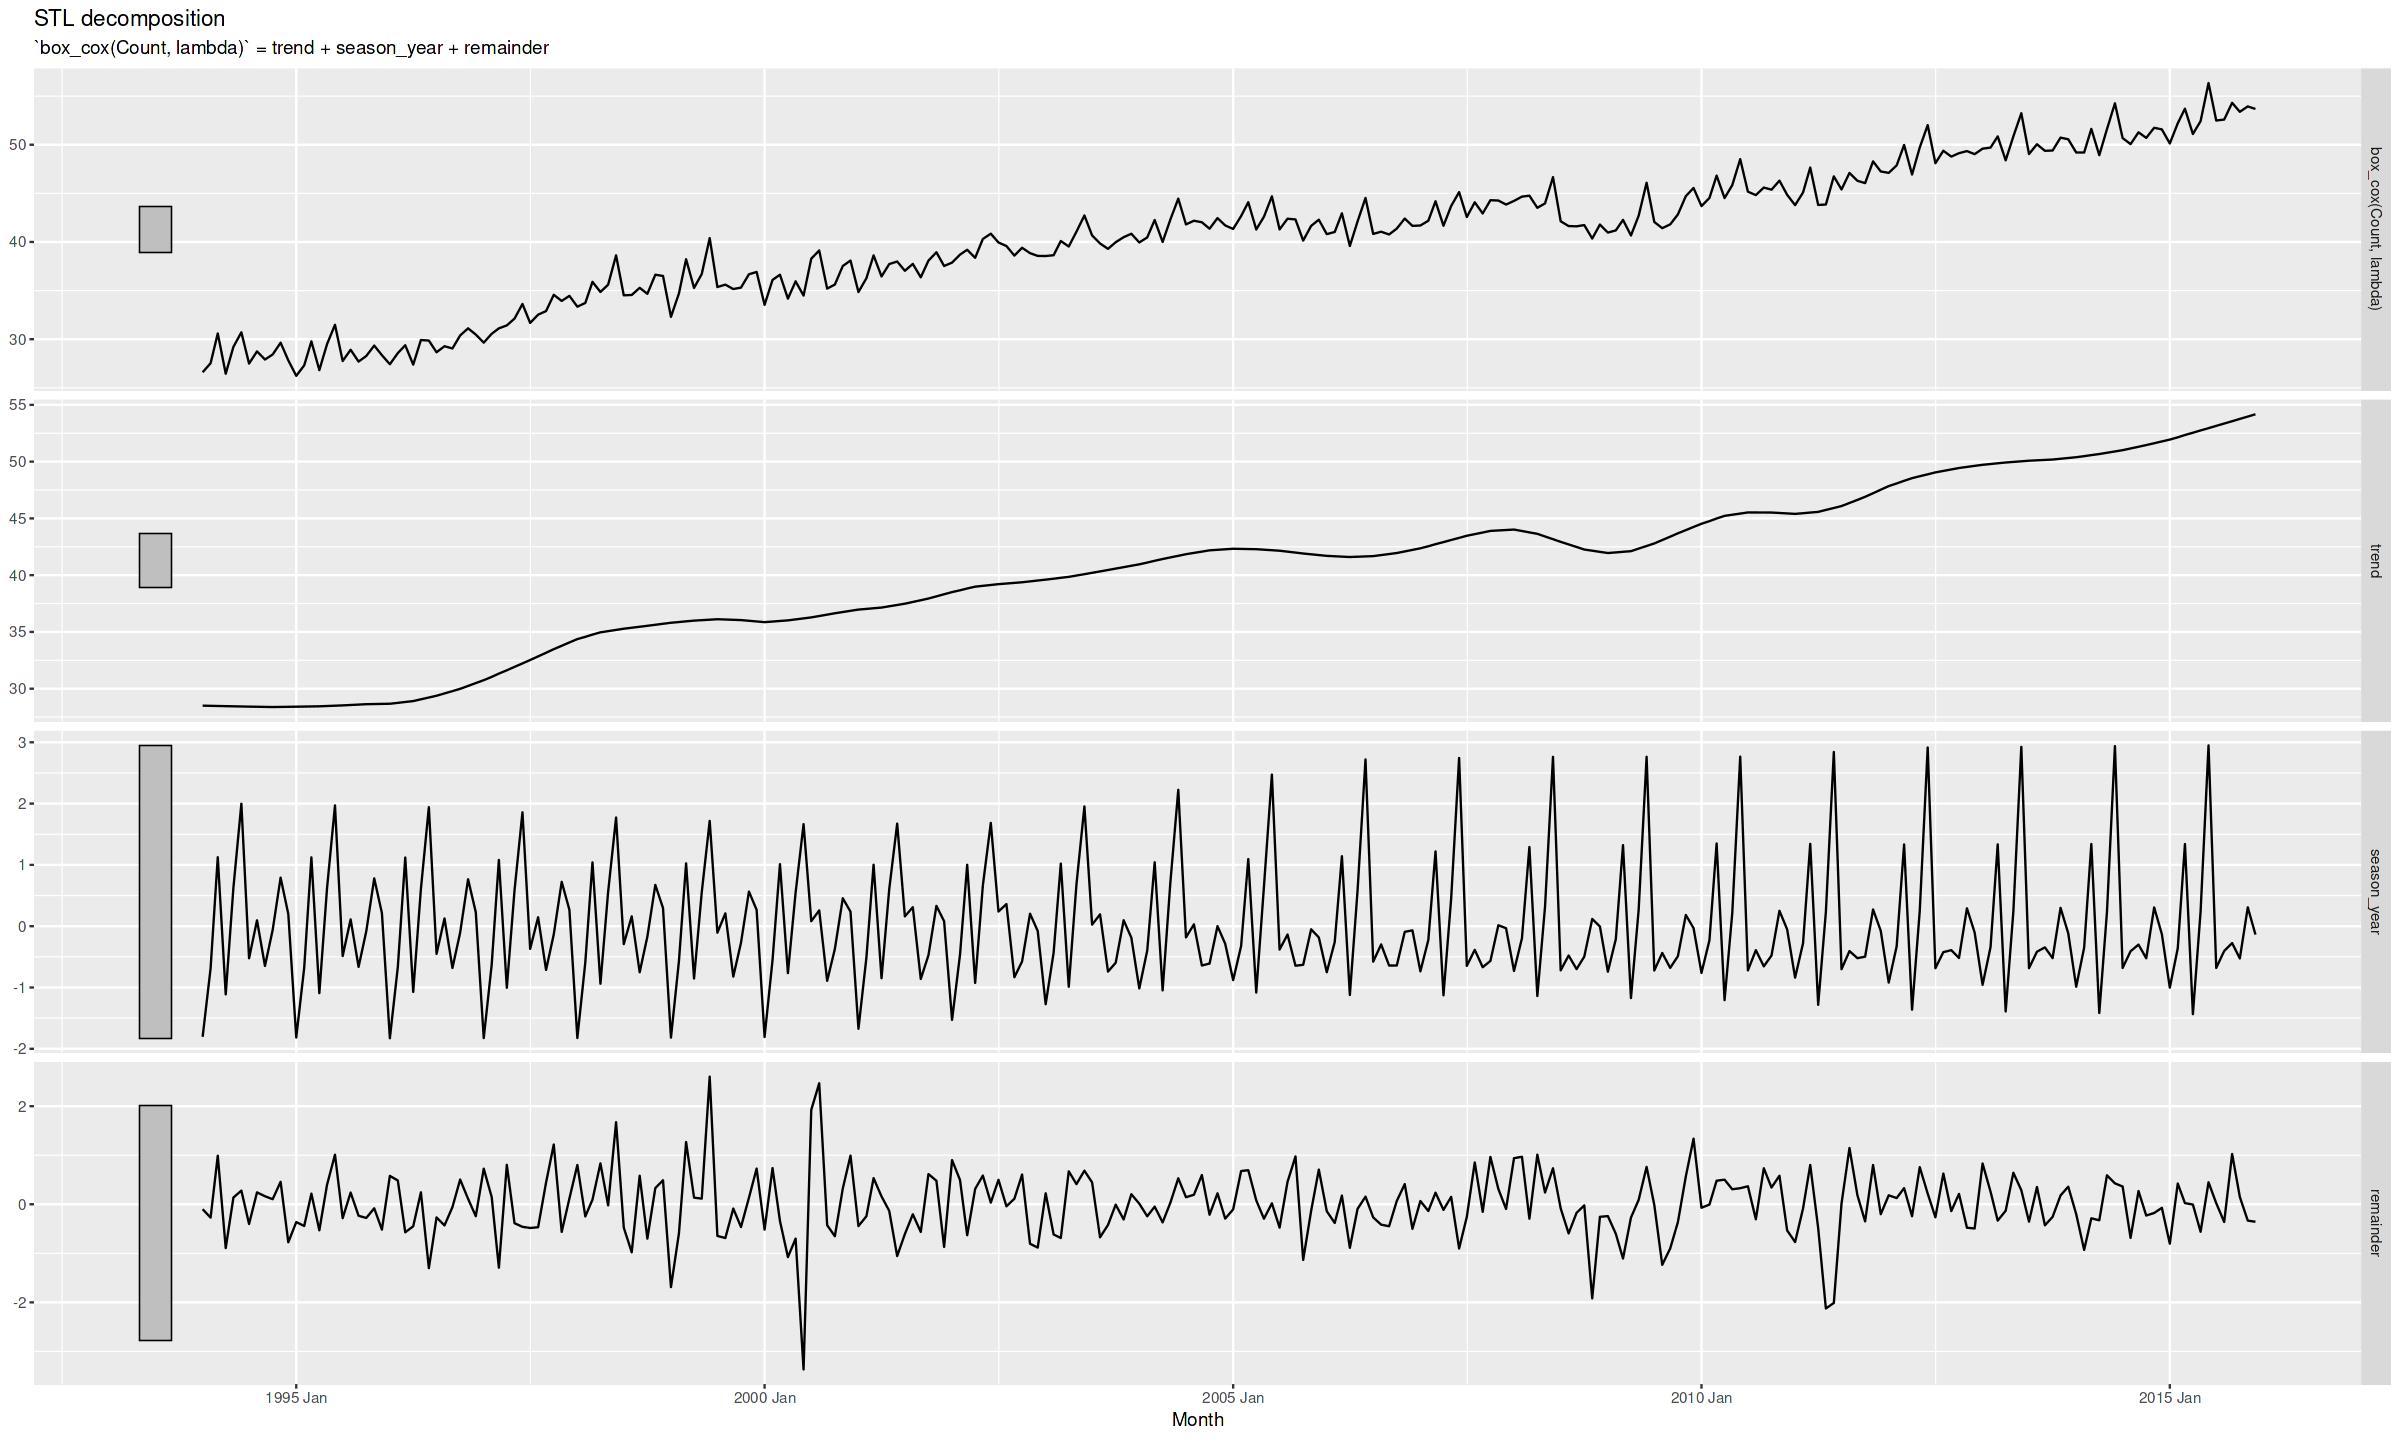

In [73]:
components(dcmp) |> autoplot()

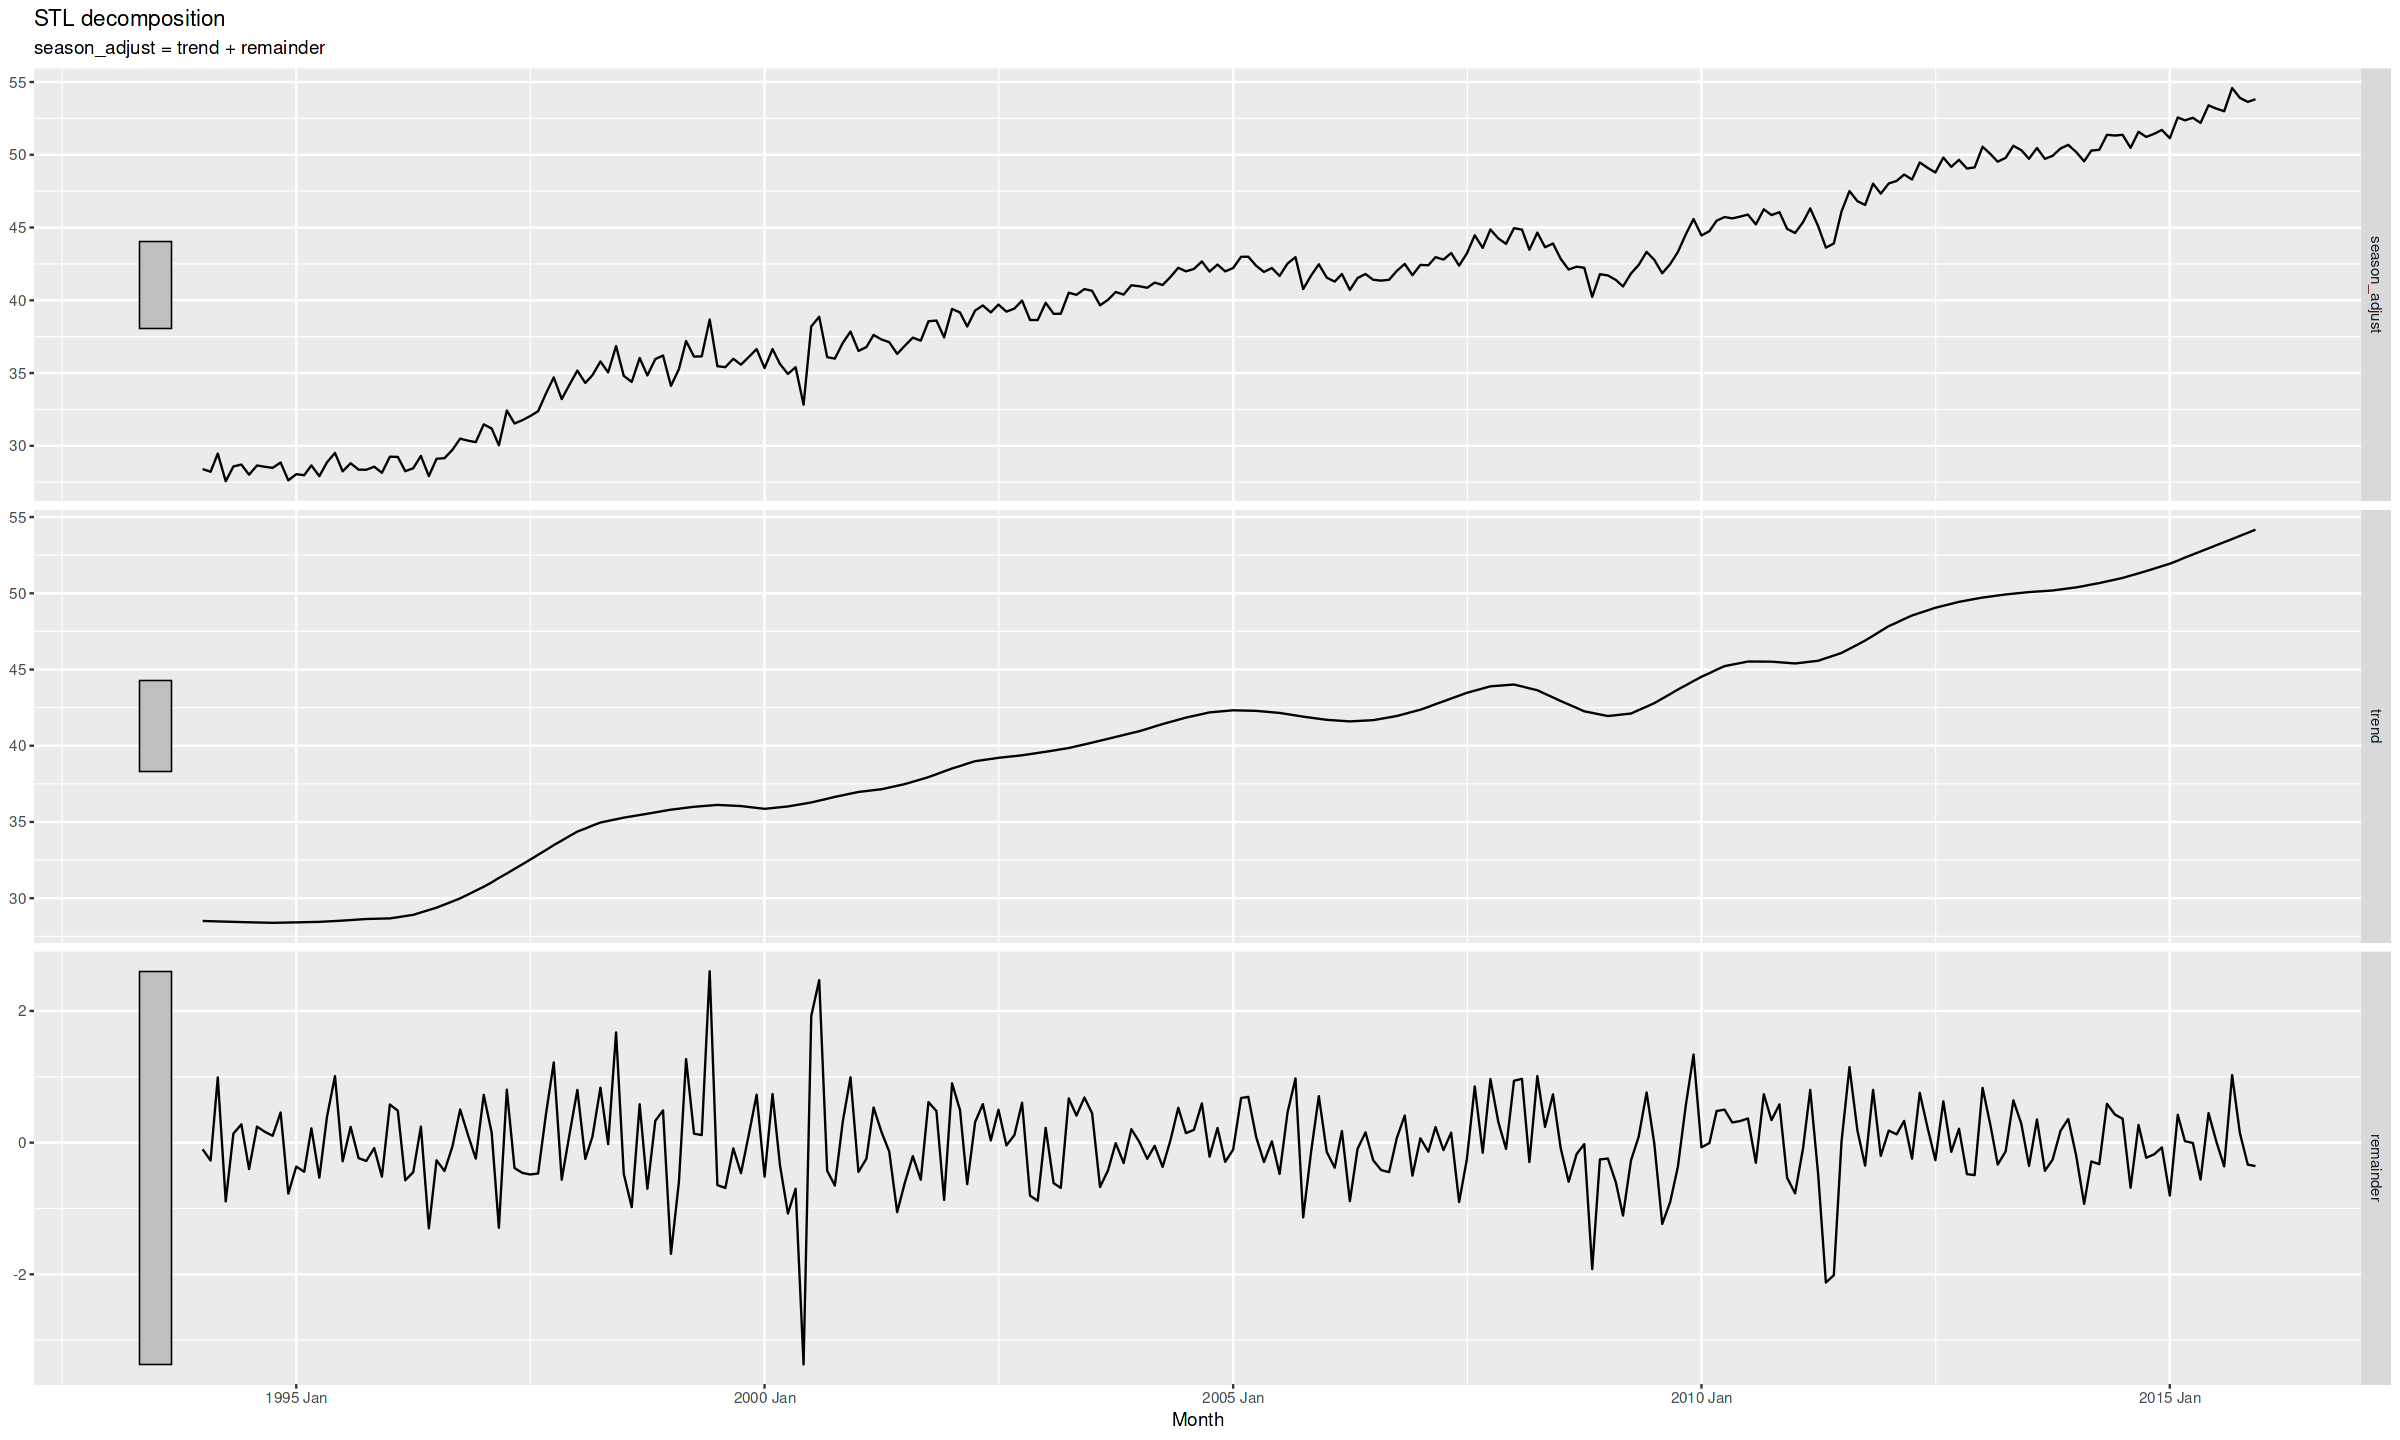

In [74]:
components(dcmp) |> autoplot(season_adjust)

## Data Inspection
In this section, I manually explored the parameters for the Seasonal ARIMA model by analyzing the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots. I tested models with only seasonal differencing (d=0, D=1) as well as models with both seasonal and regular differencing (d=1, D=1).

In [75]:
suv_train |> features(box_cox(Count, lambda), unitroot_nsdiffs)

Type nsdiffs
1 SUV  1

In [76]:
suv_train |> features(difference(box_cox(Count, lambda),12), unitroot_ndiffs)

Type ndiffs
1 SUV  0

Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”


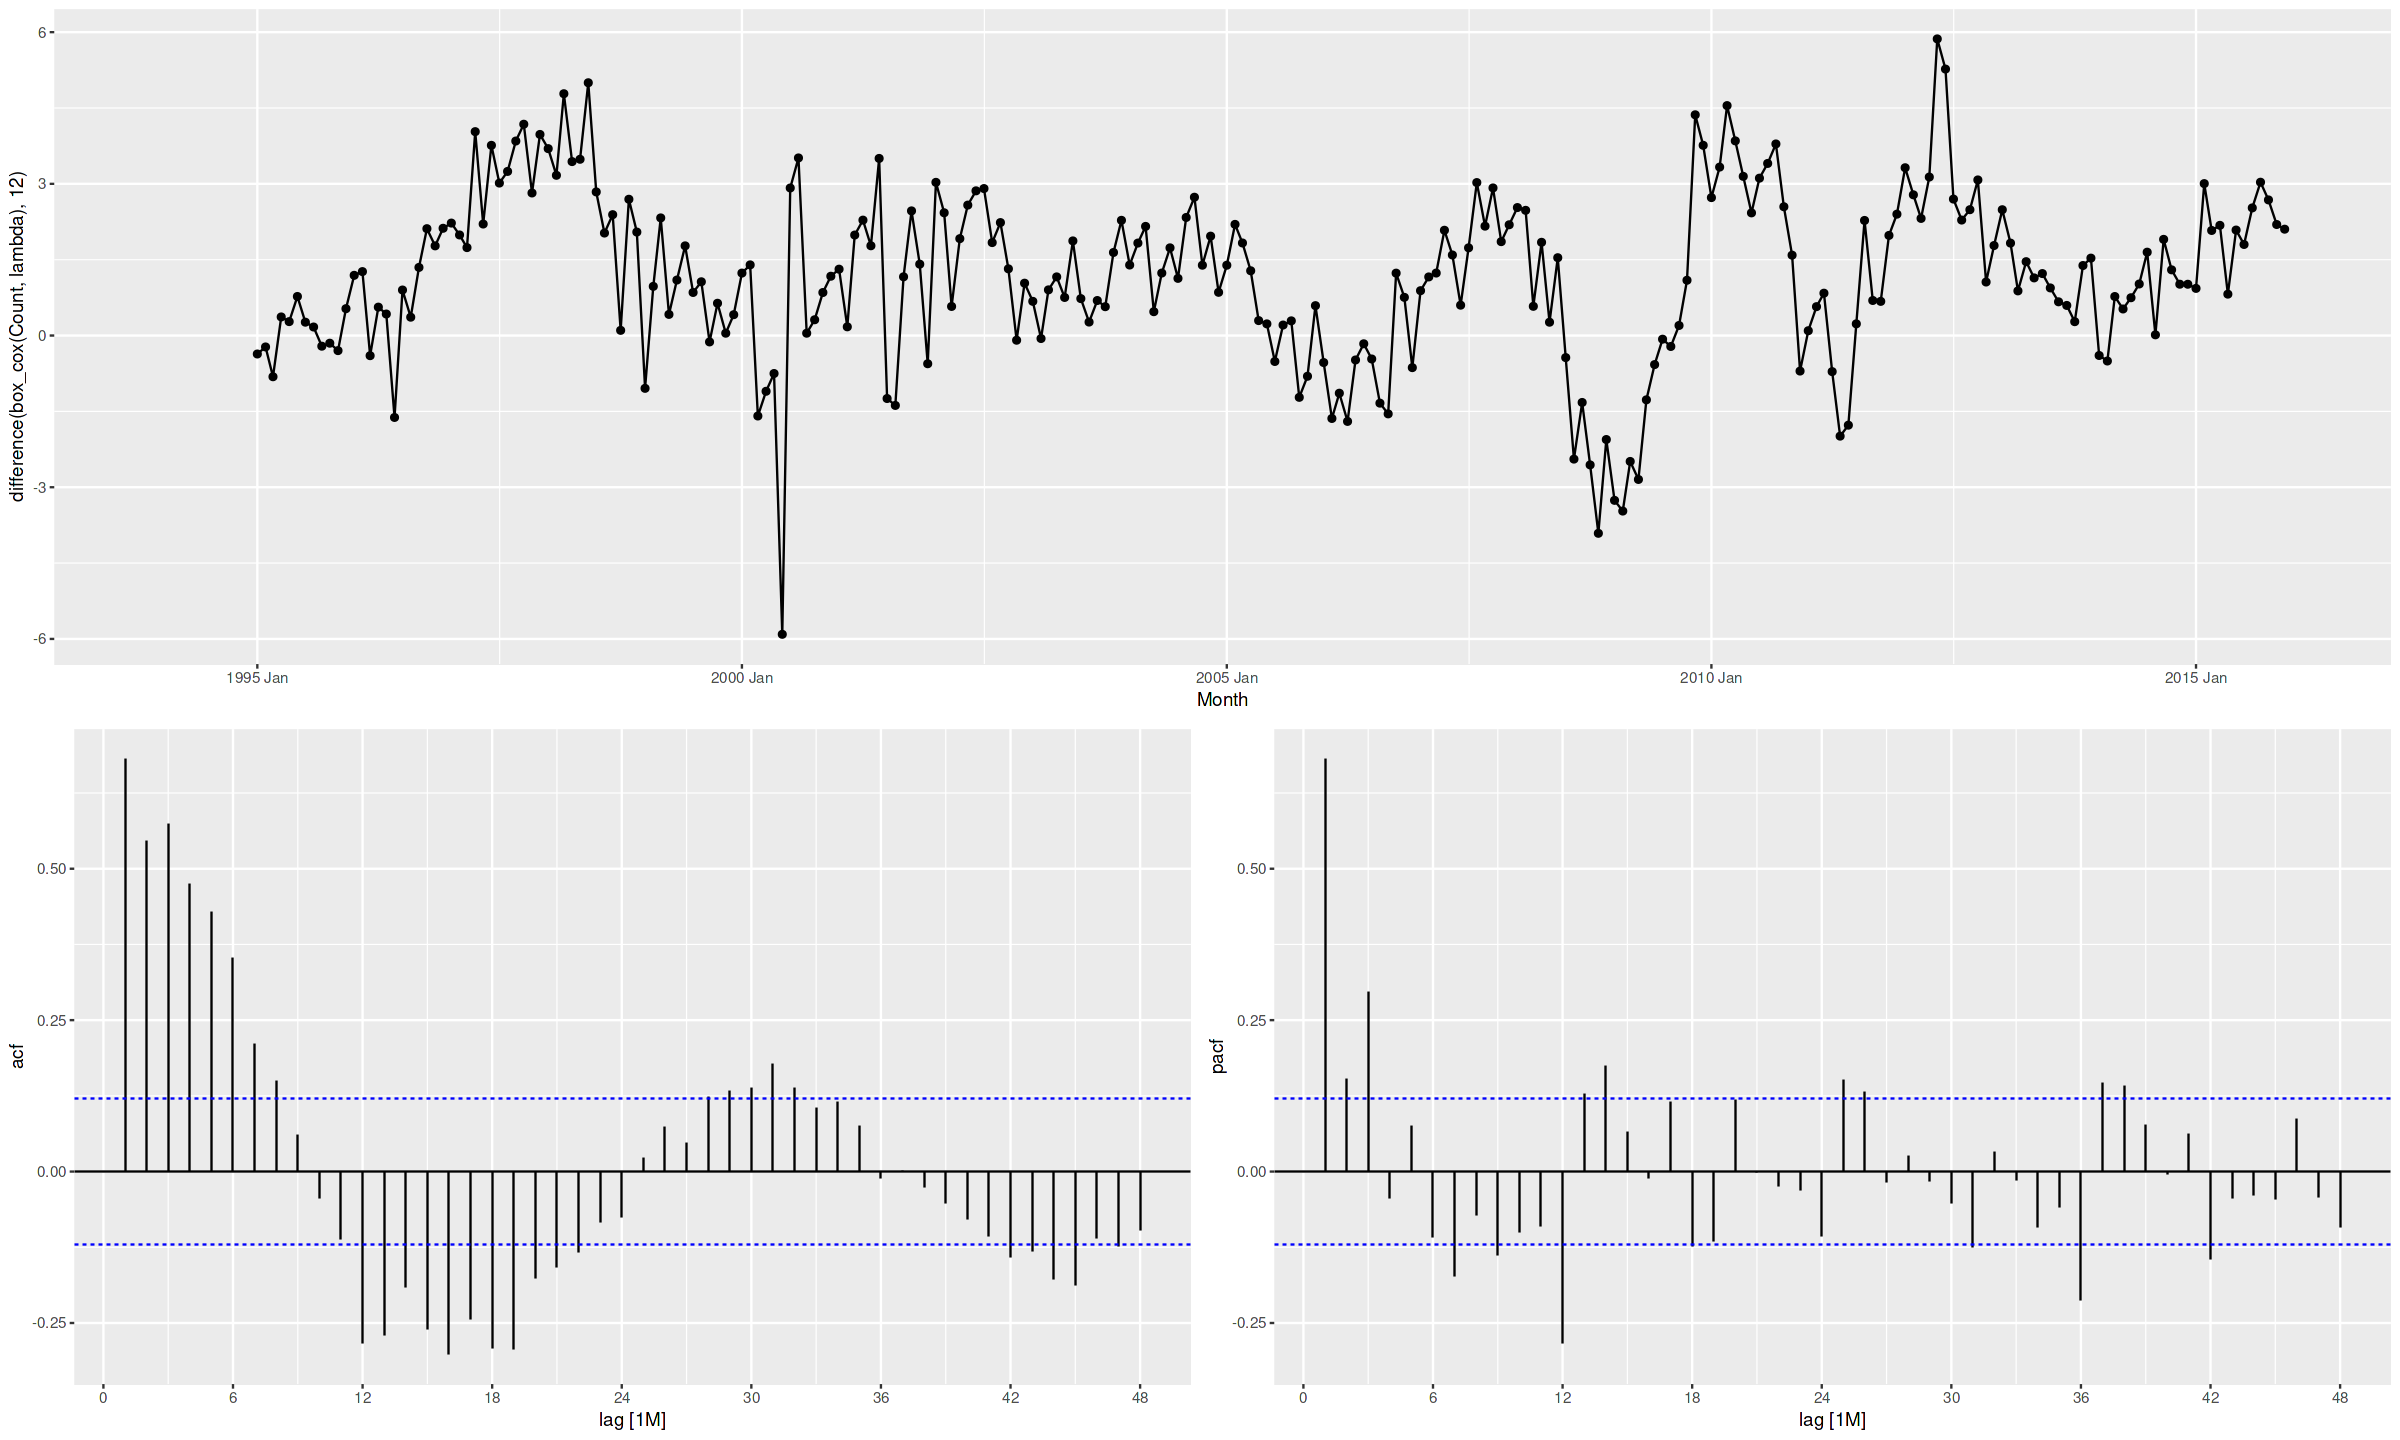

In [77]:
suv_train |> gg_tsdisplay(difference(box_cox(Count, lambda),12), plot_type = "partial", lag = 48)

Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_point()`).”


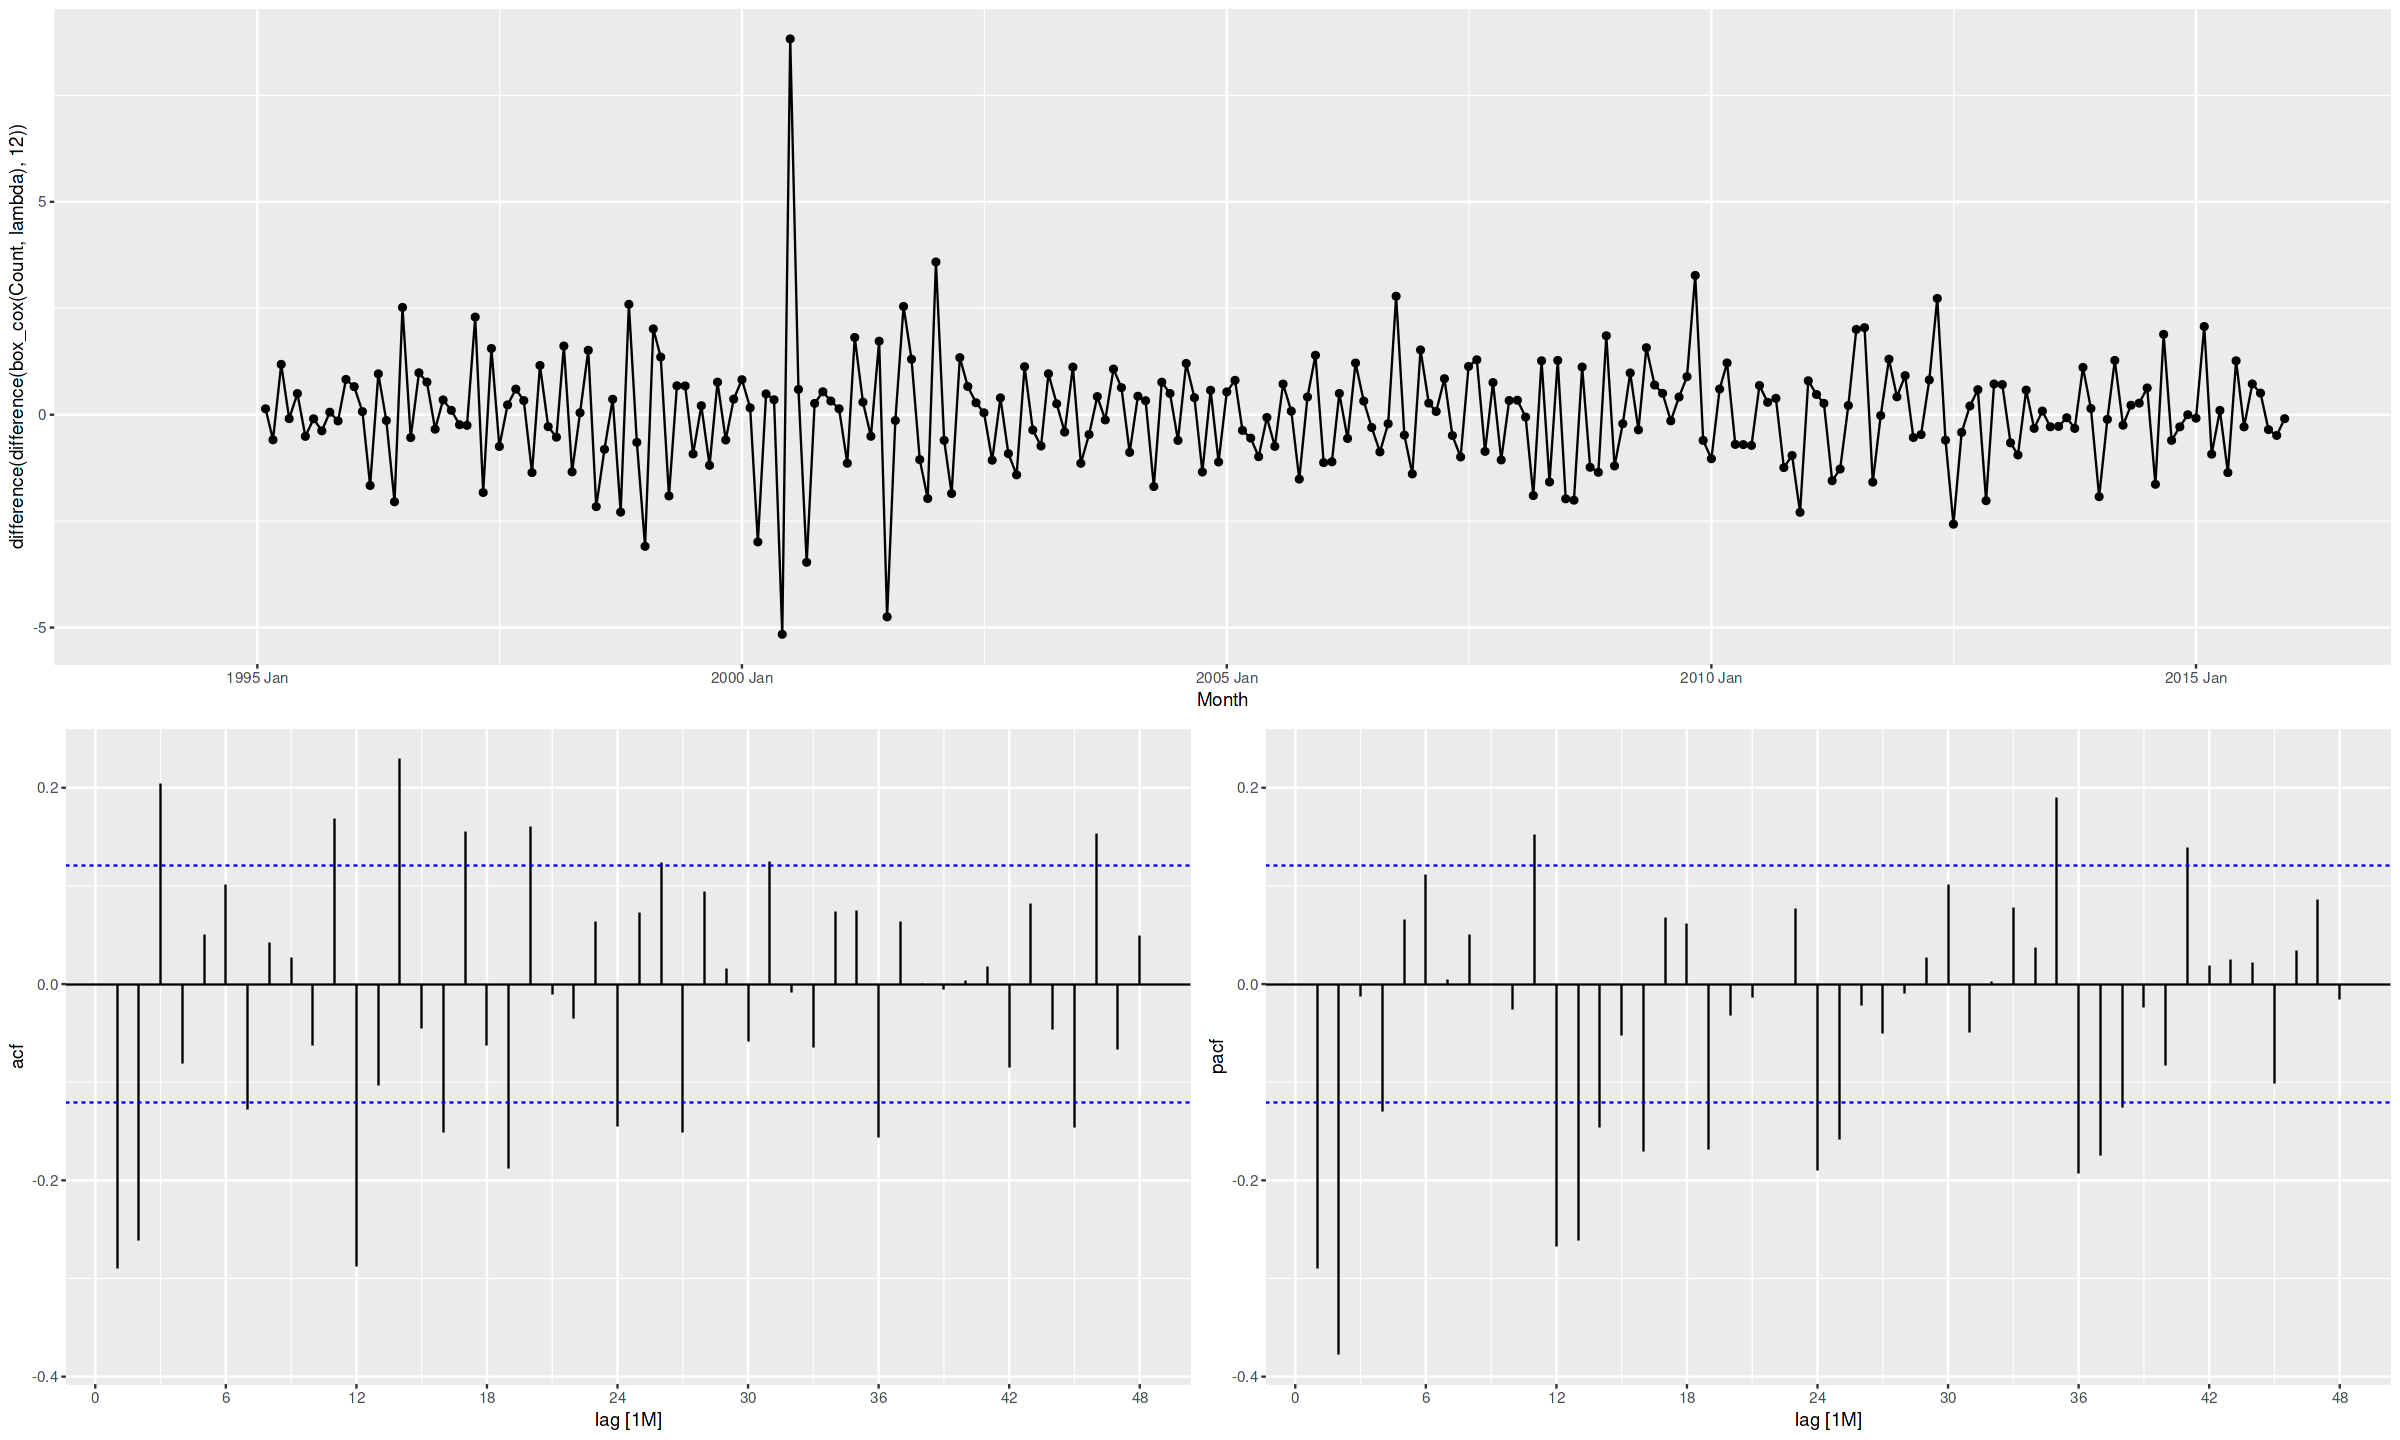

In [78]:
suv_train |> gg_tsdisplay(difference(box_cox(Count, lambda),12) |> difference(), plot_type = "partial", lag = 48)

## Data Modeling

In [79]:
fit <- suv_train |>
    model(
        Mean = MEAN(box_cox(Count, lambda)),
        Naive = NAIVE(box_cox(Count, lambda)),
        Drift = NAIVE(box_cox(Count, lambda) ~ drift()),
        SNaive = SNAIVE(box_cox(Count, lambda)),
        stl = decomposition_model(
            STL(box_cox(Count, lambda)),
            ETS(season_adjust)
        ),
        ets = ETS(box_cox(Count, lambda)),
        arima300210 = ARIMA(box_cox(Count, lambda) ~ 0 + pdq(3,0,0) + PDQ(2,1,0)),
        arima013310 = ARIMA(box_cox(Count, lambda) ~ 0 + pdq(0,1,0) + PDQ(3,1,0)),
        arima210310 = ARIMA(box_cox(Count, lambda) ~ 0 + pdq(2,1,0) + PDQ(3,1,0)),
        arima013013 = ARIMA(box_cox(Count, lambda) ~ 0 + pdq(0,1,3) + PDQ(0,1,3)),
        arima210013 = ARIMA(box_cox(Count, lambda) ~ 0 + pdq(2,1,0) + PDQ(0,1,3)),
        arima_step = ARIMA(box_cox(Count, lambda), stepwise = FALSE),
        arima_comp = ARIMA(box_cox(Count, lambda), stepwise = FALSE, approx = FALSE)
    )

## Forecasting

In [80]:
fc <- fit |> forecast(h = "2 years")

## Testing
Based on the test error evaluations, the best-performing models are:

- **ARIMA(3,0,0)(2,1,0)[12]**: This model provided strong performance, capturing the underlying patterns of the time series.

- **STL (Seasonal and Trend decomposition using Loess)**: STL decomposition followed by forecasting also yielded reliable results.

  
- **Automatic ARIMA Step/ARIMA Comp Models**: These models, which were selected automatically based on their performance, delivered excellent forecasts.

In [81]:
accuracy(fc, suv)

.model      Type .type ME         RMSE      MAE       MPE         MAPE     
1  Drift       SUV  Test  -3632.7921  5857.358  5075.451 -10.5776333 13.657569
2  Mean        SUV  Test  22952.0313 23348.958 22952.031  60.2968757 60.296876
3  Naive       SUV  Test   -119.4742  4080.801  2830.462  -1.3619832  7.330249
4  SNaive      SUV  Test   3369.0324  3961.979  3431.916   8.7262199  8.906217
5  arima013013 SUV  Test  -2125.1598  2909.679  2610.305  -6.0294591  7.098785
6  arima013310 SUV  Test  -5156.9747  5811.069  5163.294 -13.7929607 13.810103
7  arima210013 SUV  Test  -1845.5344  2706.280  2432.179  -5.2814258  6.598412
8  arima210310 SUV  Test  -3903.1982  4345.063  3934.087 -10.5617597 10.645548
9  arima300210 SUV  Test   -605.8956  1502.901  1180.333  -1.8905083  3.226475
10 arima_comp  SUV  Test   -193.5390  1874.610  1359.608  -0.9435333  3.589433
11 arima_step  SUV  Test   -193.5390  1874.610  1359.608  -0.9435333  3.589433
12 ets         SUV  Test  -1191.3268  2480.595  2165.013  -3.5935241  5.797647
13 stl         SUV  Test  -1382.6556  2177.567  1931.736  -3.9954559  5.258339
   MASE       RMSSE     ACF1       
1   2.5001930 2.2233743  0.06696782
2  11.3062868 8.8629507 -0.09375322
3   1.3942998 1.5490173 -0.17673340
4   1.6905793 1.5039139  0.12965183
5   1.2858494 1.1044751  0.08353676
6   2.5434649 2.2058036  0.73913439
7   1.1981039 1.0272675  0.08775975
8   1.9379511 1.6493274  0.56317975
9   0.5814381 0.5704811  0.02454221
10  0.6697496 0.7115767 -0.03385485
11  0.6697496 0.7115767 -0.03385485
12  1.0664961 0.9416006 -0.03512302
13  0.9515831 0.8265753  0.15457209

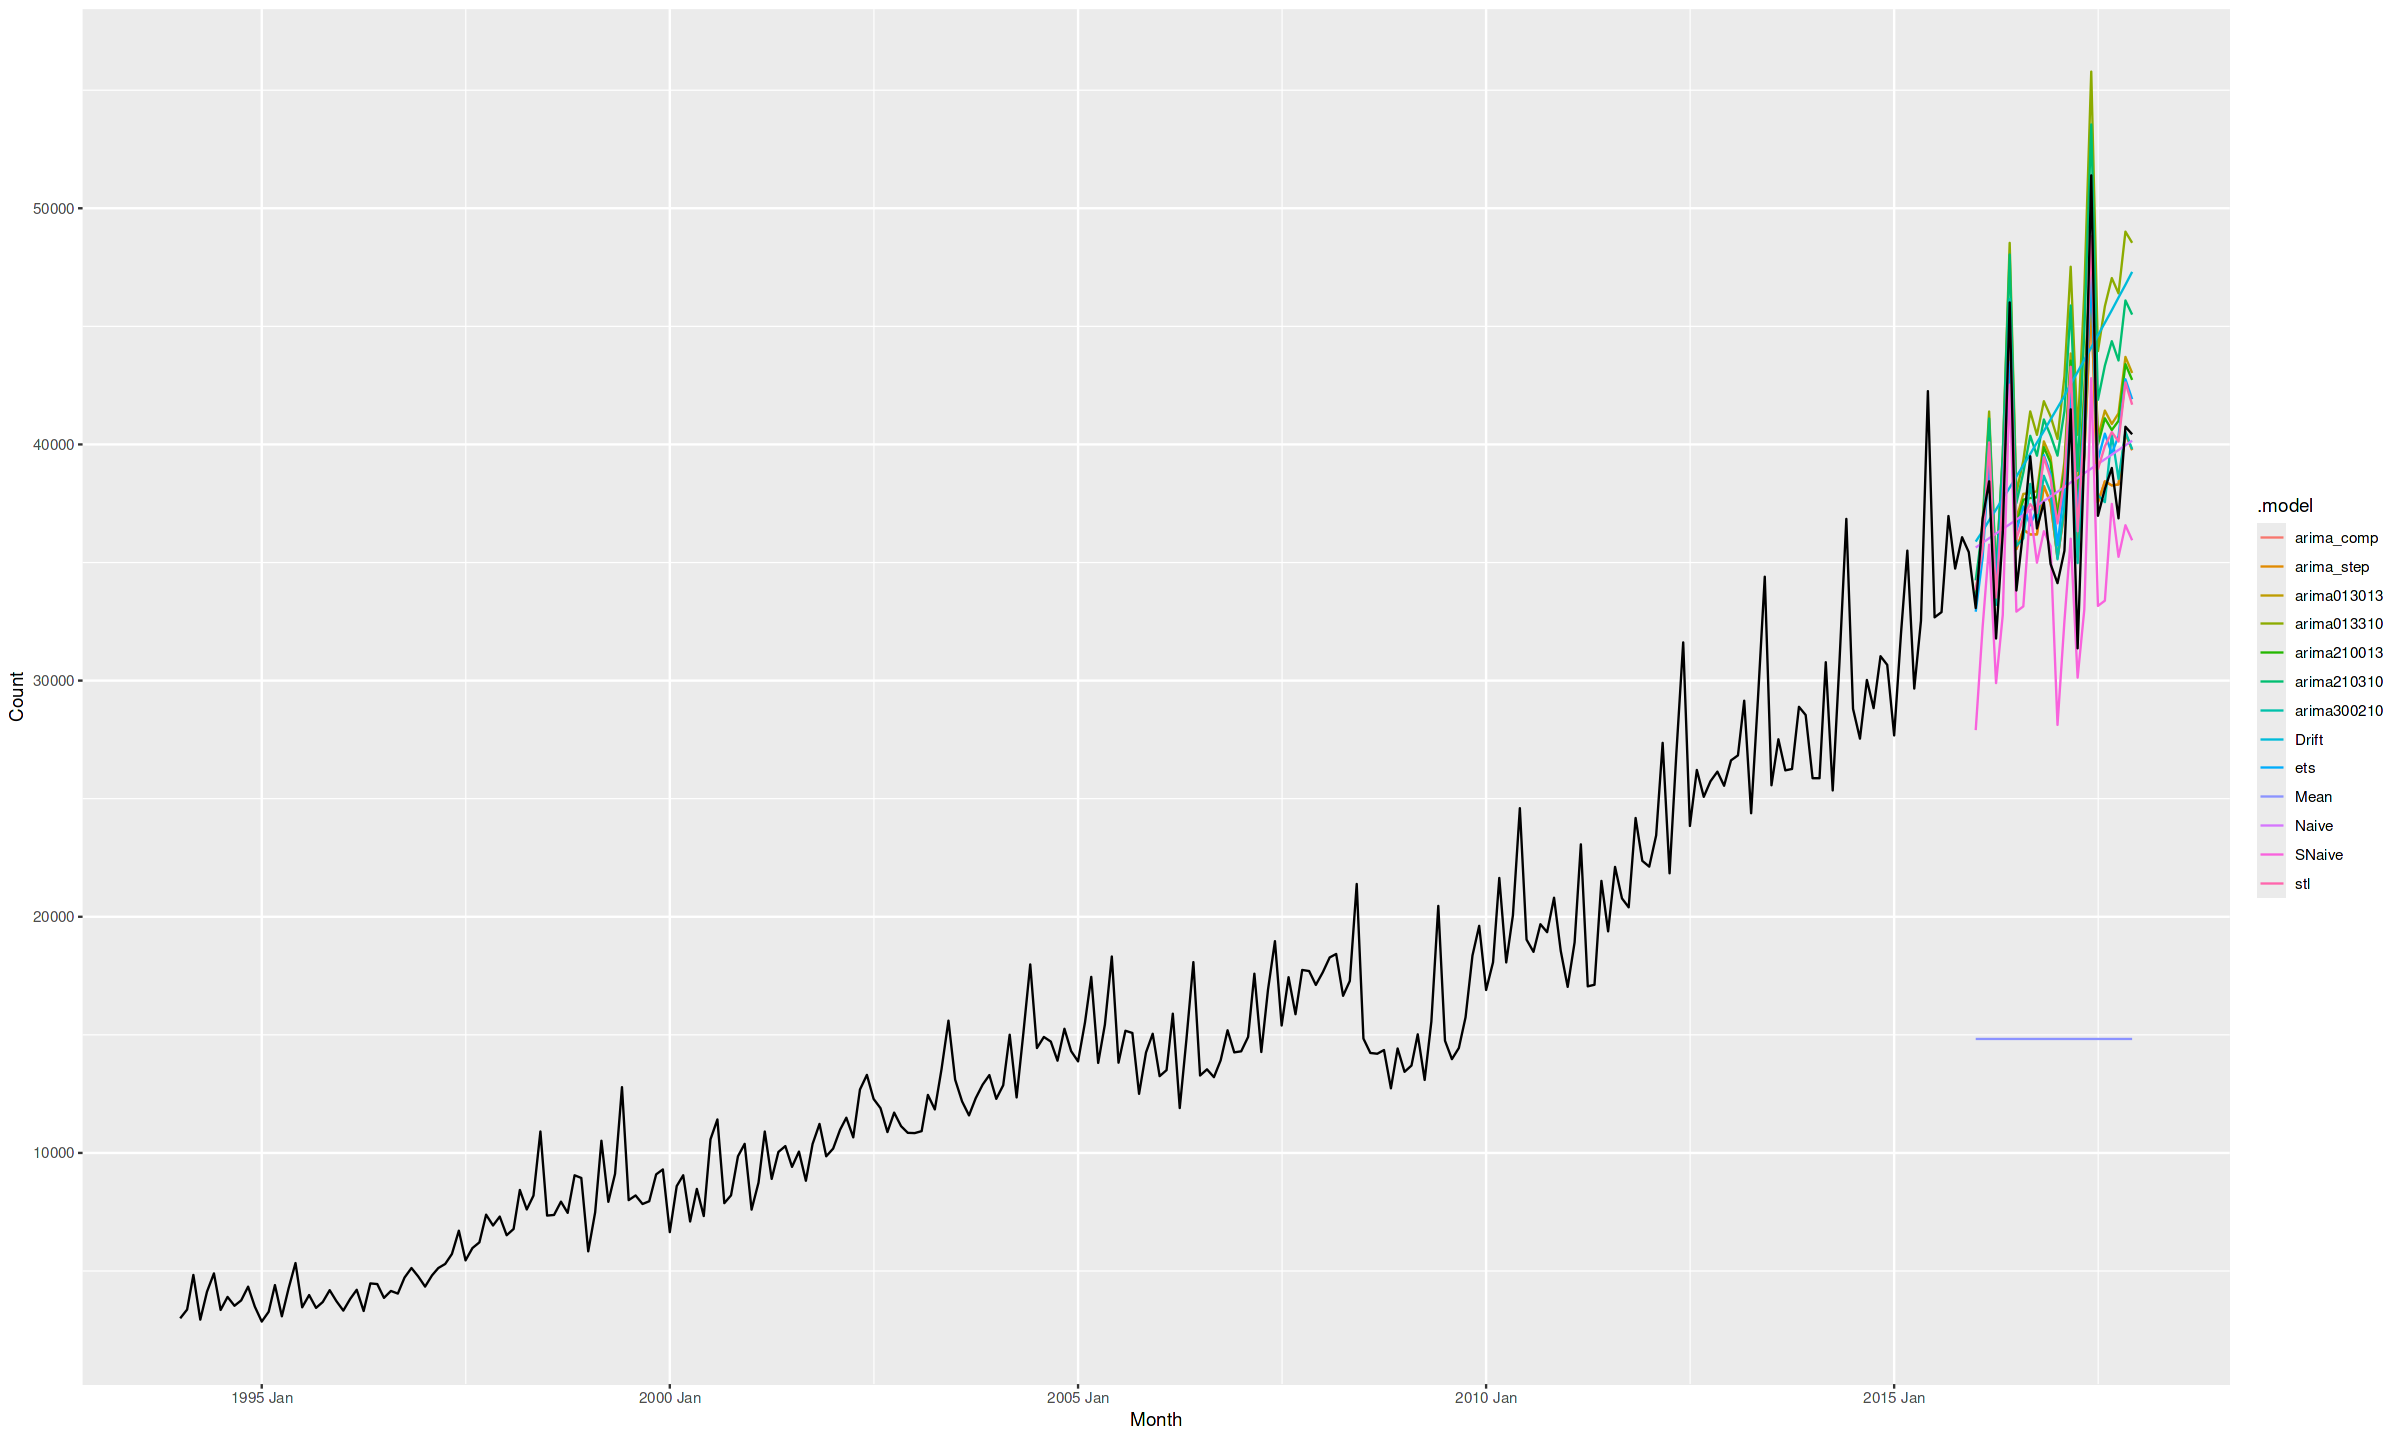

In [82]:
fc |> autoplot(suv, level = NULL)

## Residual Diagnostics
In this section, I evaluated the residuals of the best fitted models to ensure that they meet the assumptions of white noise, i.e., that the residuals are uncorrelated and normally distributed. I used diagnostic tools such as the ACF of residuals, as well as statistical tests like the Ljung-Box test, to check for any patterns or autocorrelations in the residuals.

Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 12 rows containing non-finite outside the scale range (`stat_bin()`).”


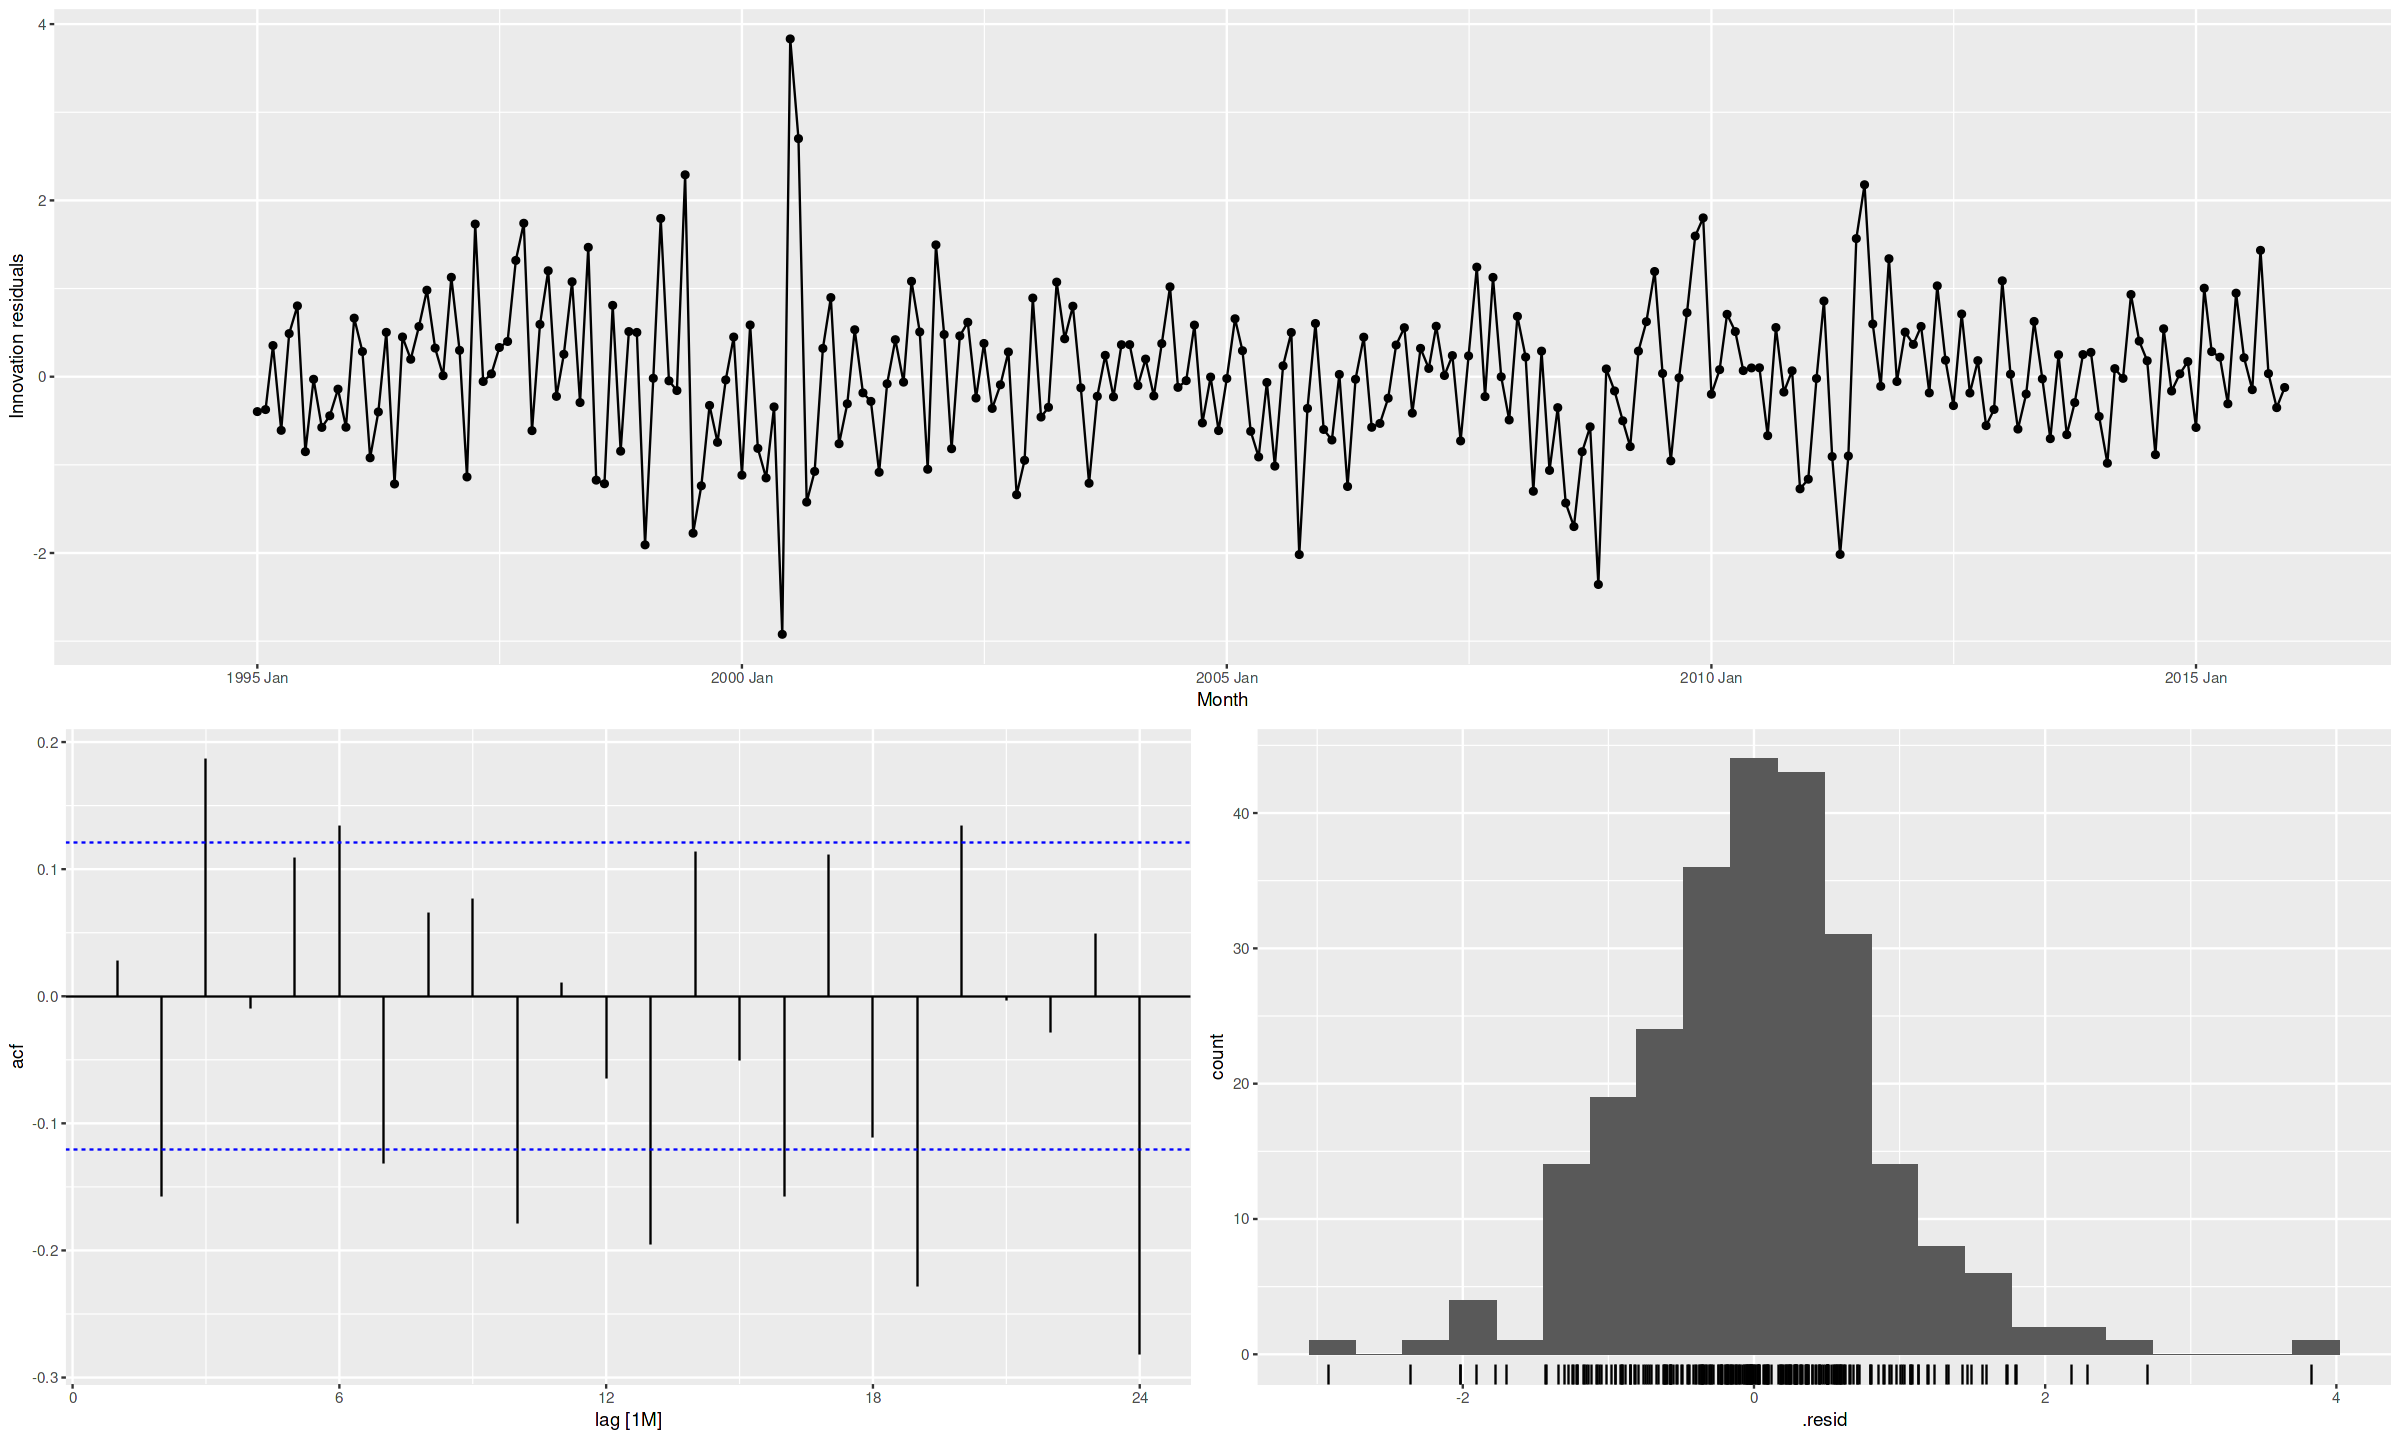

In [83]:
fit |> select(stl) |> gg_tsresiduals()

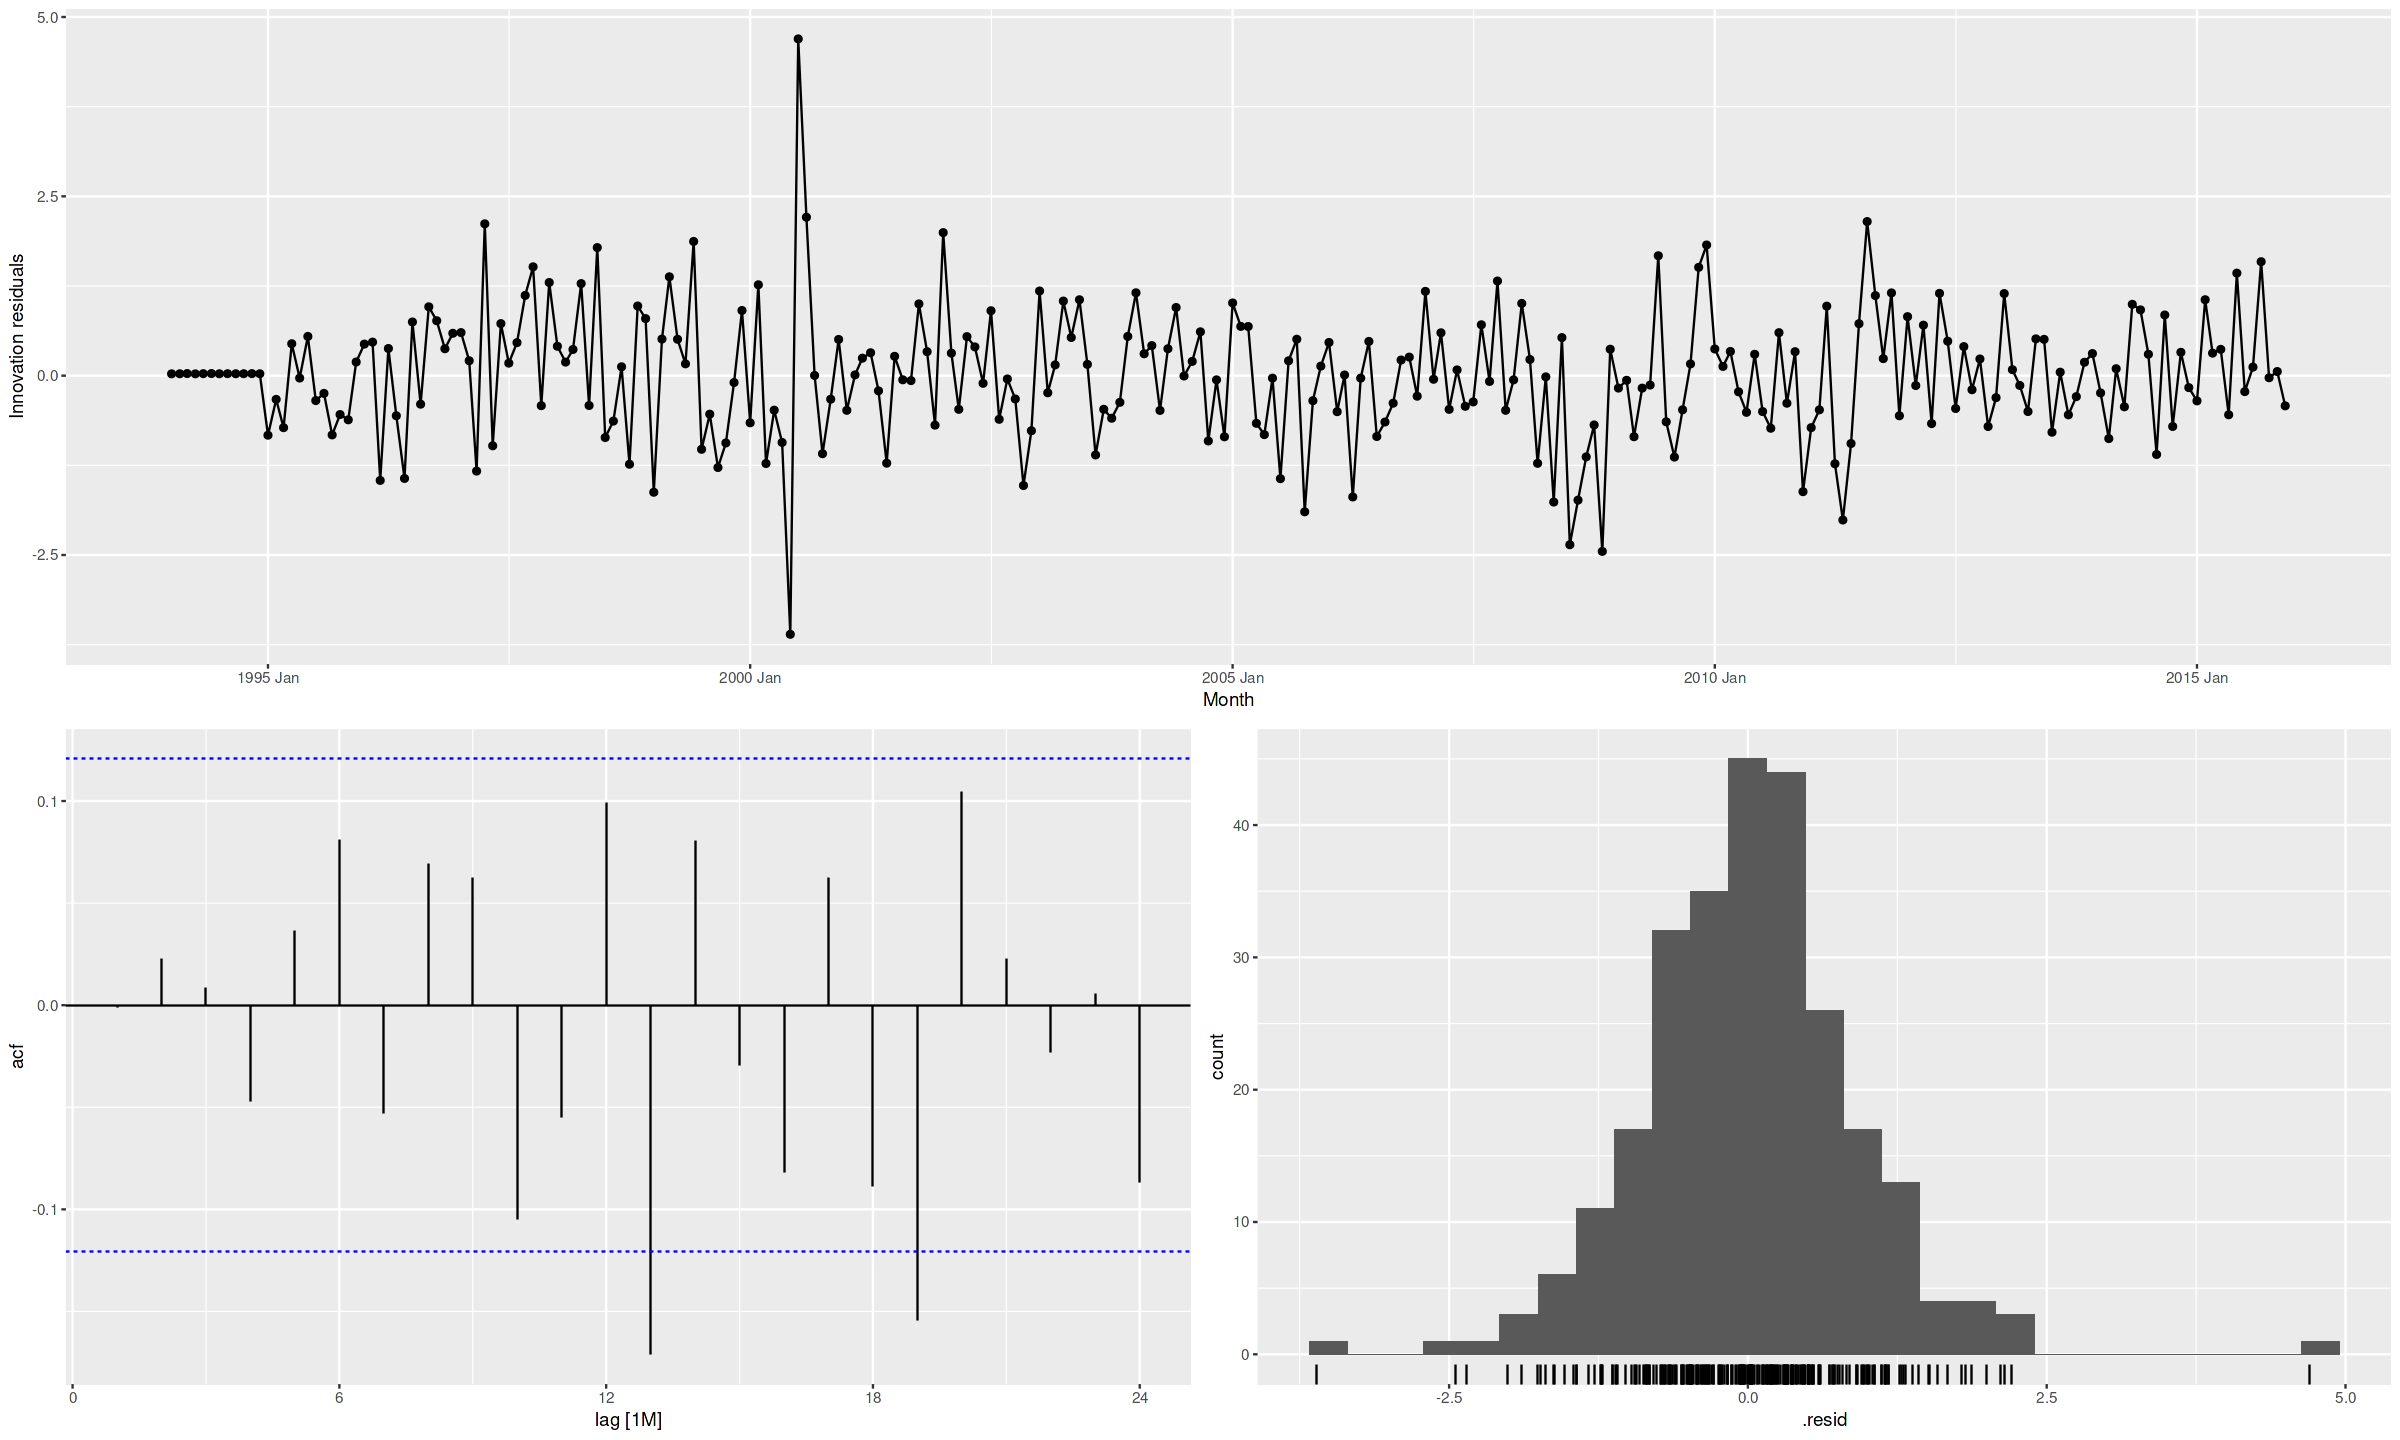

In [84]:
fit |> select(arima_step) |> gg_tsresiduals()

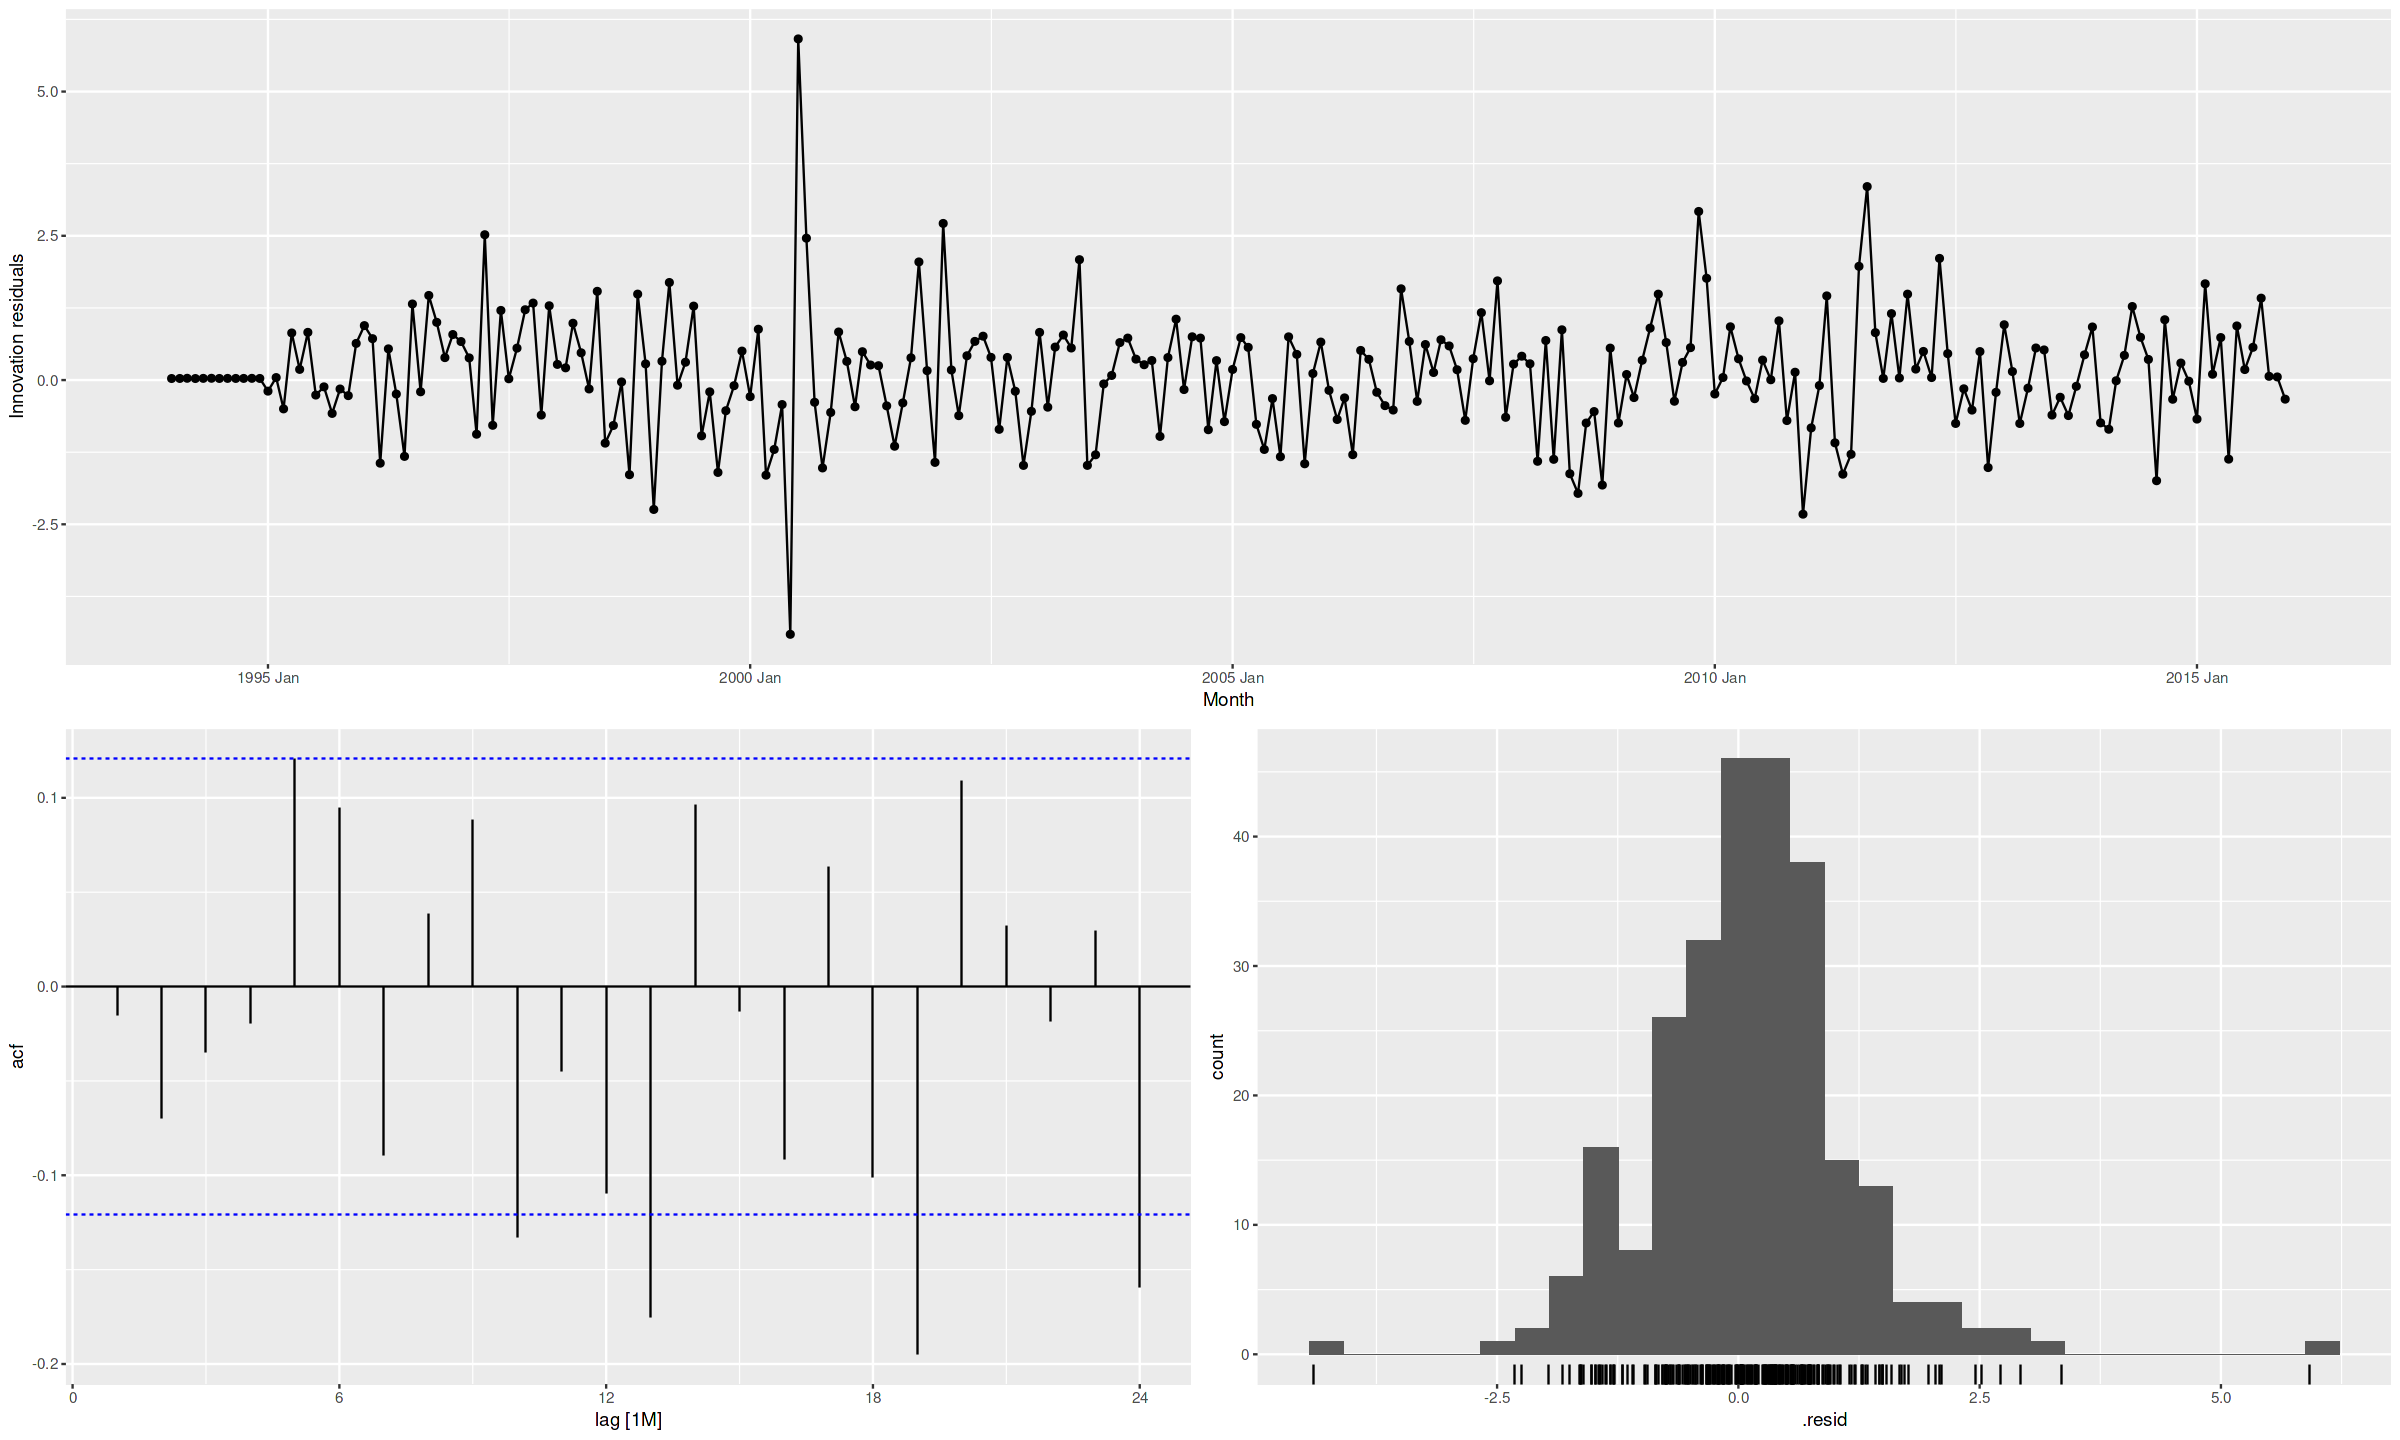

In [85]:
fit |> select(arima300210) |> gg_tsresiduals()

In [86]:
fit |> select(stl) |> augment() |> features(.innov, ljung_box, lag = 12)

.model lb_stat  lb_pvalue  
1 stl    40.19788 6.66677e-05

In [87]:
fit |> select(arima_step) |> augment() |> features(.innov, ljung_box, lag = 12)

.model     lb_stat  lb_pvalue
1 arima_step 12.71177 0.3903341

In [88]:
fit |> select(arima300210) |> augment() |> features(.innov, ljung_box, lag = 12)

.model      lb_stat  lb_pvalue
1 arima300210 21.78039 0.0400561

## Final Thoughts
Even though the residuals of the ARIMA(3,0,0)(2,1,0)[12] model are not white noise, it performed the best in terms of test errors. The automatic ARIMA model had white noise residuals, indicating a better fit, but since the ARIMA(3,0,0)(2,1,0)[12] model gave the lowest test error, I decided to use it as the final model.

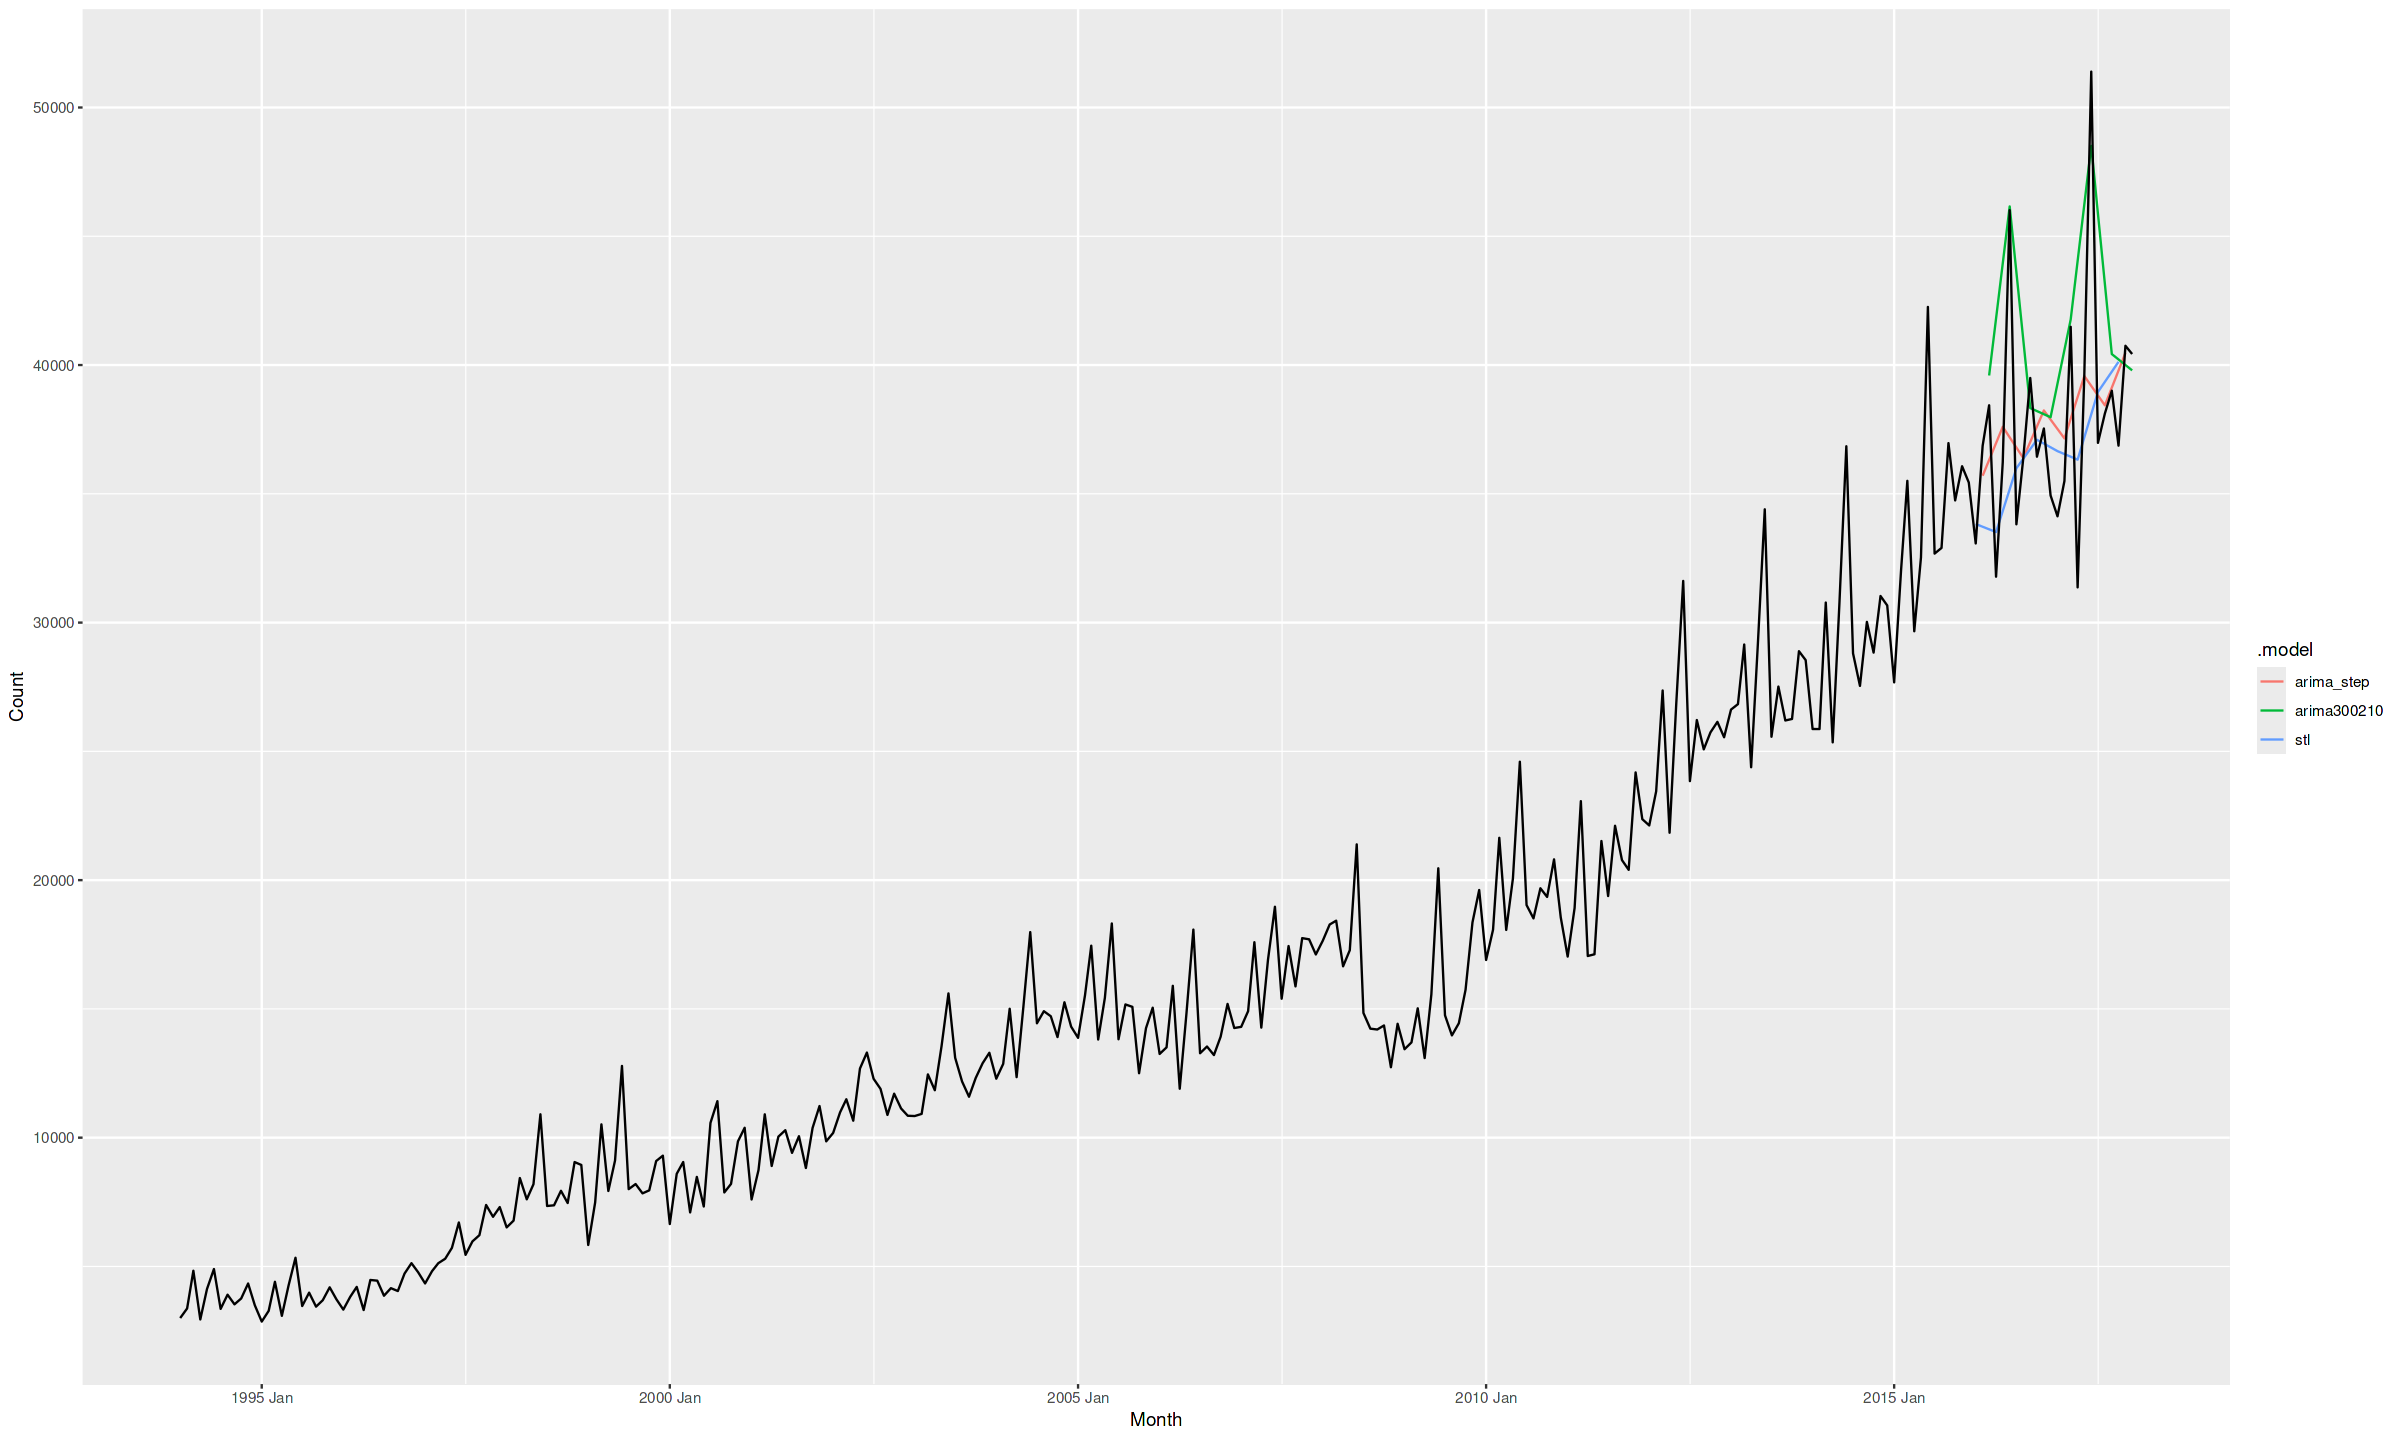

In [89]:
fc |> filter(.model == c("stl", "arima_step", "arima300210")) |> autoplot(suv, level = NULL)

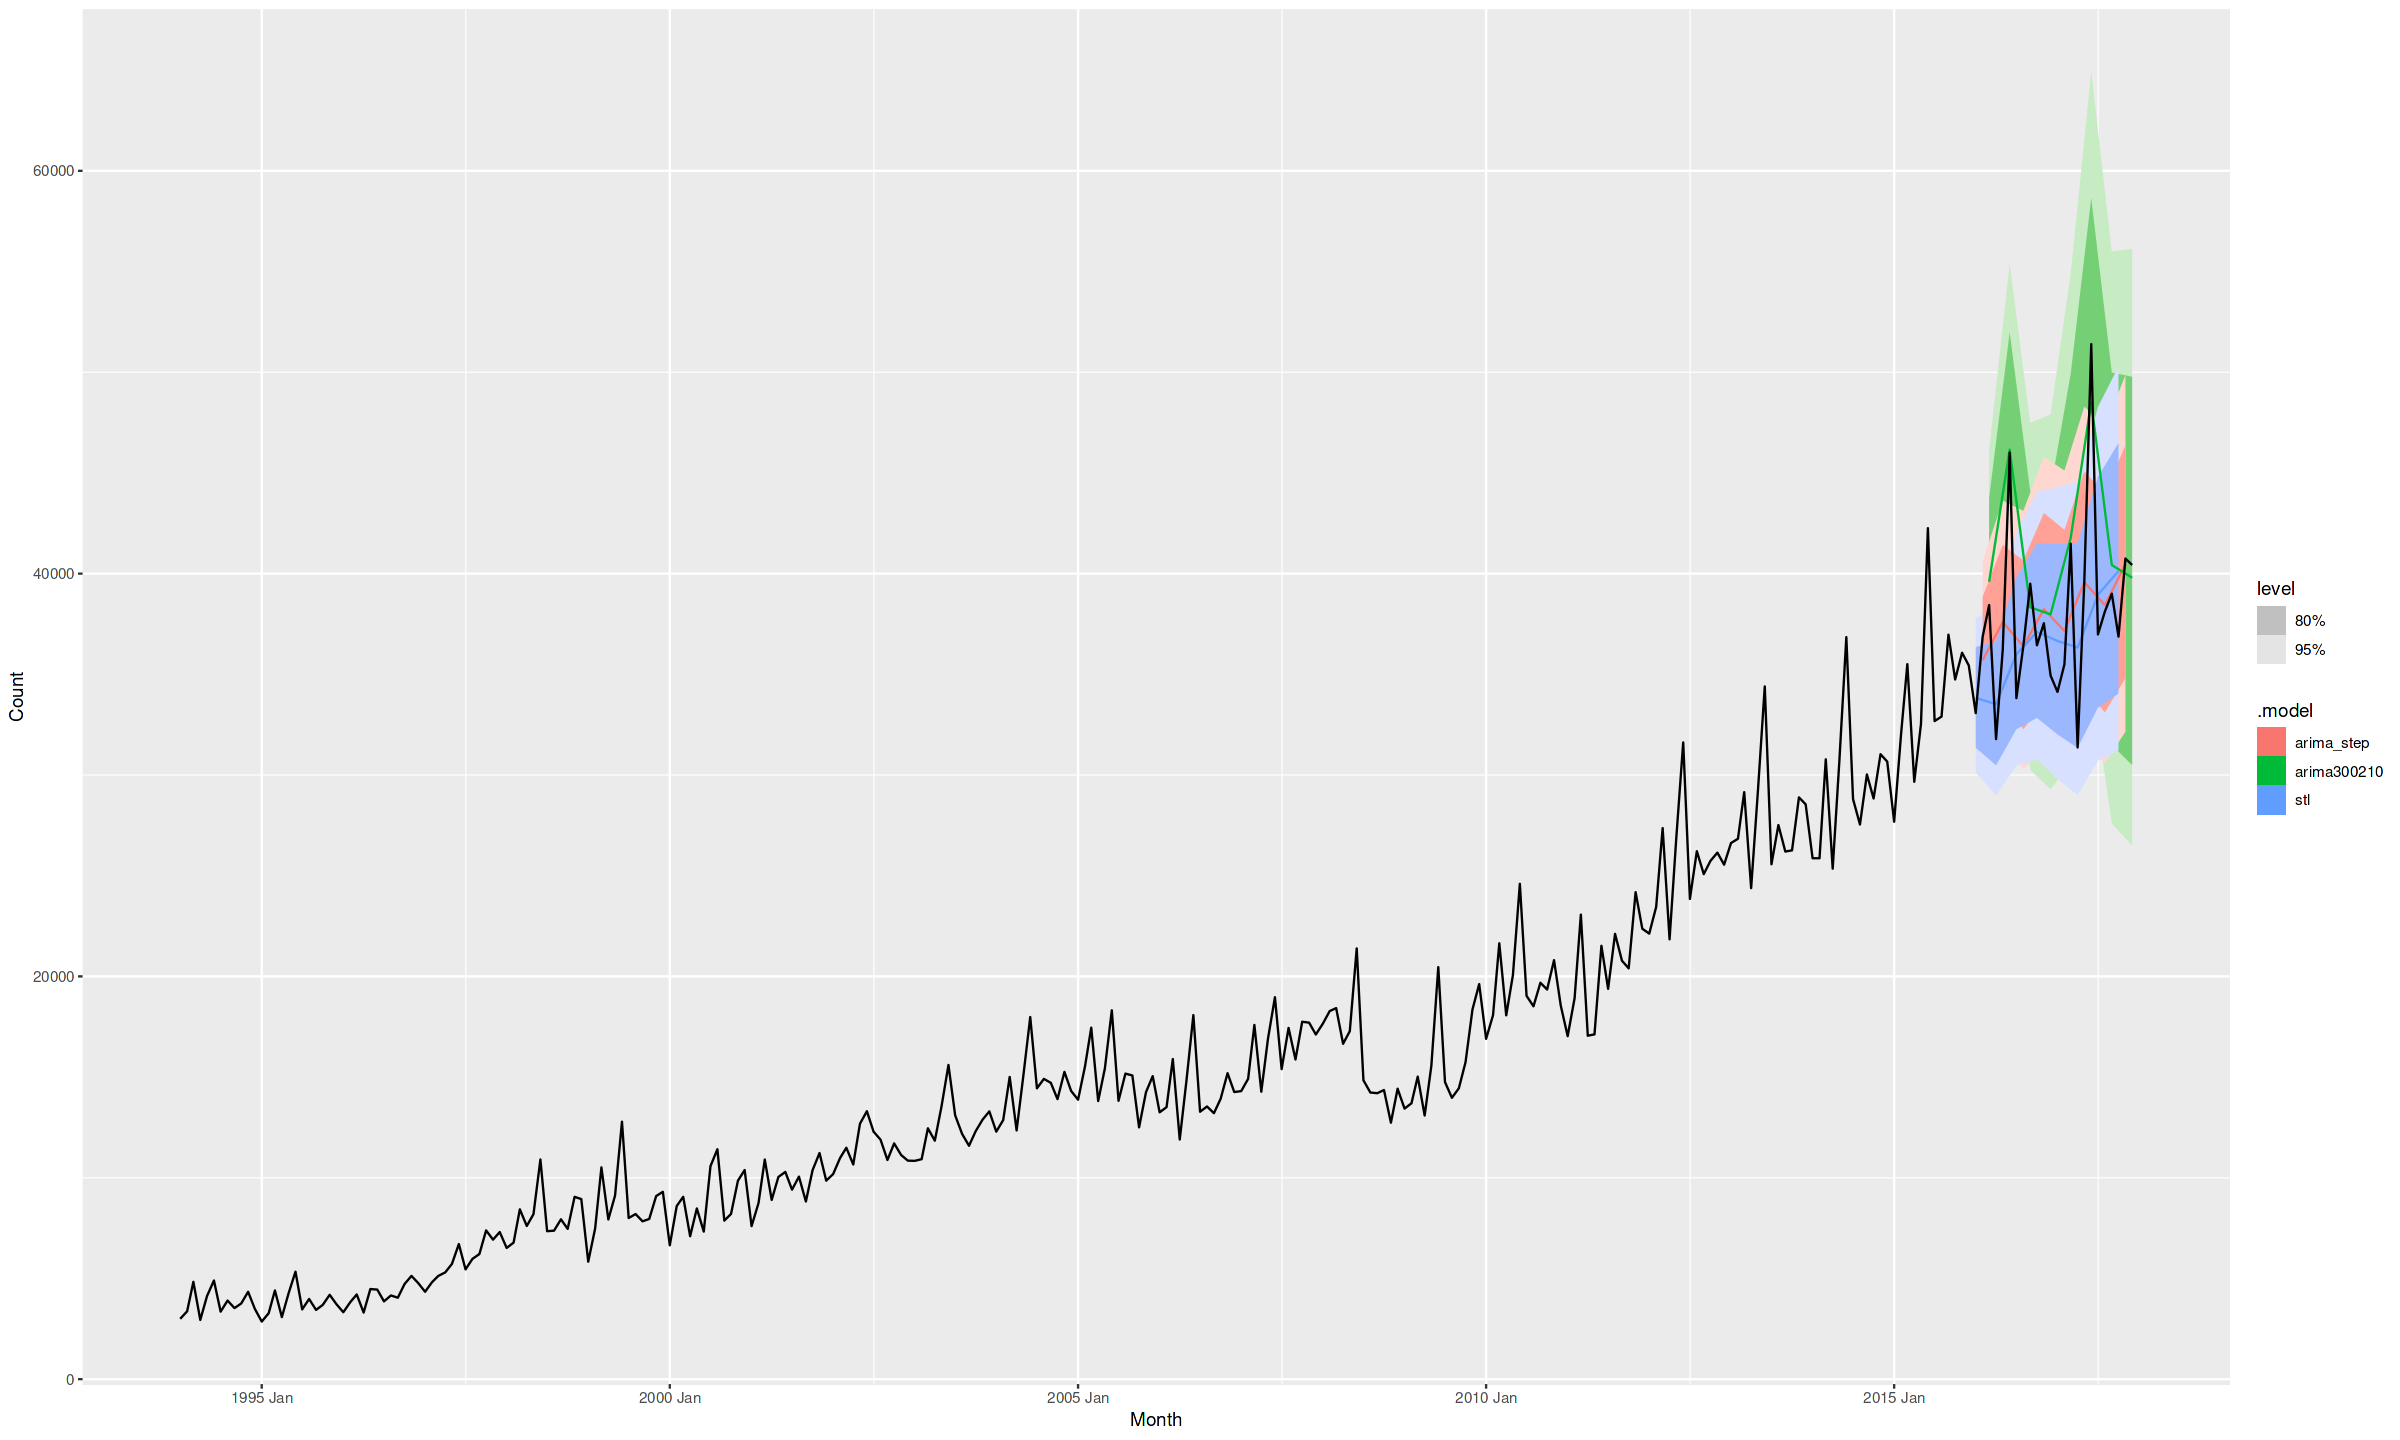

In [90]:
fc |> filter(.model == c("stl", "arima_step", "arima300210")) |> autoplot(suv)